# Title: Control method for seasonal epidemics

## Libraries needed

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
from datetime import datetime
from datetime import date
import colormap
from scipy import signal
from matplotlib.colors import ListedColormap, BoundaryNorm

## Read the data

We are using daily data from SIVIC (https://sivic.salut.gencat.cat/) of influenza and bronchiolitis diagnoses.

In [94]:
day = '16062023'
path_to_sivic_data = r'C:\Users\A. Perramon Malavez\OneDrive - Universitat Politècnica de Catalunya\Escritorio\BIOCOM-SC\PhD Marató\SISAP\dades_sivic_' + day + '.xlsx'
sivic_data = pd.read_excel(path_to_sivic_data)

In [95]:
sivic_data.head()

,data,diagnostic,sexe,grup_edat,casos
0,2016-04-04,ILI,Dona,75 a 79,132
1,2017-02-20,ILI,Dona,55 a 59,184
2,2021-12-18,COVID-19,Dona,55 a 59,151
3,2022-04-19,COVID-19,Dona,40 a 44,262
4,2019-03-09,ILI,Dona,35 a 39,85


The dataset from SIVIC has five features: 
- data: the date of diagnosis of that patient (the present dataset has data from 01-09-2011 to 24-04-2023, although we will focus on the study period 01-09-2011 to 31-03-2023).
- diagnostic: the diagnose the patient obtained.
- sexe: the sex of the patient, cathegorised as "Home" for "Male" and "Dona" for "Women".
- grup_edat: the age group the patient is in.
- casos: the number of cases reported in a day of a certain diagnoses for the age group and sex specified.

In [96]:
# We gather separetely the data from bronchiolitis (bronquiolitis in Catalan) and from influenza (Grip in Catalan). 
bronchiolitis = sivic_data[sivic_data.diagnostic == 'Bronquiolitis']
influenza = sivic_data[sivic_data.diagnostic == 'Grip']

## Pre-process the data

We will now pre-process the data. In a separate file, we have computed the reporting weights for each day of the week in a "Nowcasting" approach. We consider as consolidated the data reported more than three weeks ago, and estimate the final number of cases of the last three weeks of data with report daily weights. We implement that with the following function:

In [97]:
from datetime import timedelta
def preprocess_SIVIC_report(dataframe, weights):
    # Only valid for SIVIC data, if other data, change variable names
    df_adapted = dataframe[['data','casos']]
    df_adapted.index = pd.DatetimeIndex(df_adapted.data).floor('D')
    df_adapted = df_adapted[['casos']]
    df_adapted = df_adapted.resample('D').sum()

    day = df_adapted.index.max()
    start_day = day - timedelta(days=29)
    dates = pd.date_range(start=start_day, end=day)

    for i in range(len(dates)):
        df_adapted.loc[dates[i], 'casos'] /= weights[i]

    df_adapted = df_adapted[['casos']]
    return df_adapted


We also have to consider, that there is a periodic weekly pattern for the data affected by non-laboral days. We have to account for that pattern and adjust the number of cases reported each day of the week, during the whole study period. These weights have been estimated in a separate file. The function implementing these weekly weights goes as follows:

In [98]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, Easter, Day
from pandas.tseries.offsets import CustomBusinessDay

def adjust_daily_values(df, weights, N):
# We create a Calendar of Catalan non-laboral days, since we are dealing with catalan data.
    class CatCalendar(AbstractHolidayCalendar):
        rules = [
         Holiday('Any Nou', month=1, day=1),
         Holiday('Reis', month=1, day=6),
         Holiday('Divendres SS', month=1, day=1, offset=[Easter(), Day(-2)]),
         Holiday('Dilluns de Pasqua', month=1, day=1, offset=[Easter(), Day(1)]),
         Holiday('Pentecosta', month=1, day=1, offset=[Easter(), Day(49)]),
         Holiday('Dia del Treballador', month=5, day=1),
         Holiday('Sant Joan', month=6, day=24),
         Holiday('Dia Asumpció', month=8, day=15),
         Holiday('Diada', month=9, day=11),
         Holiday('Dia del Pilar', month=10, day=12),
         Holiday('Tots Sants', month=11, day=1),
         Holiday('Dia Constitució', month=12, day=6),
         Holiday('Immaculada Concepció', month=12, day=8), 
         Holiday('Nadal', month=12, day=25),
         Holiday('Sant Esteve', month=12, day=26),
       ]

    cal = CatCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())

    conditions = [
        (df.index.isin(holidays) & ~df.index.day_name().isin(['Sunday'])),
        (df.index.day_name().isin(['Monday'])),
        (df.index.day_name().isin(['Tuesday'])),
        (df.index.day_name().isin(['Wednesday'])),
        (df.index.day_name().isin(['Thursday'])),
        (df.index.day_name().isin(['Friday'])),
        (df.index.day_name().isin(['Saturday'])),
        (df.index.day_name().isin(['Sunday']))
        ]

    # create a list of the values we want to assign for each condition
    #values = [8, 1, 2, 3, 4, 5, 6, 7] 
    values = [3, 1, 2, 2, 2, 2, 3, 3] 
    df['Holidays'] = np.select(conditions, values)

    adjusted_values = []

    for cc in range(100):
        each_iteration = [];
        for j in range(len(df)):
            if df['casos'].iloc[j] >= N:
                D1 = np.random.normal(loc=weights[0], scale=1/(df['casos'].iloc[j]))
                D2 = np.random.normal(loc=weights[1], scale=1/df['casos'].iloc[j])
                D3 = np.random.normal(loc=weights[2], scale=1/df['casos'].iloc[j])
                #D4 = np.random.normal(loc=weights[3], scale=1/df['casos'].iloc[j])
                #D5 = np.random.normal(loc=weights[4], scale=1/df['casos'].iloc[j])
                #D6 = np.random.normal(loc=weights[5], scale=1/df['casos'].iloc[j])
                #D7 = np.random.normal(loc=weights[6], scale=1/df['casos'].iloc[j])
                #D8 = np.random.normal(loc=weights[7], scale=1/df['casos'].iloc[j])
                each_iteration.append(df['casos'].iloc[j] / final_weights[df['Holidays'].iloc[j] - 1])
            else:
                D1 = weights[0]
                D2 = weights[1]
                D3 = weights[2]
                #D1 = np.random.normal(loc=weights[0], scale=1/N)
                #D2 = np.random.normal(loc=weights[1], scale=1/N)
                #D3 = np.random.normal(loc=weights[2], scale=1/N)
                #D4 = np.random.normal(loc=weights[3], scale=1/N)
                #D5 = np.random.normal(loc=weights[4], scale=1/N)
                #D6 = np.random.normal(loc=weights[5], scale=1/N)
                #D7 = np.random.normal(loc=weights[6], scale=1/N)
                #D8 = np.random.normal(loc=weights[7], scale=1/N)
                each_iteration.append(df['casos'].iloc[j])
                    
            final_weights = np.array([D1, D2, D3]) #, D4, D5, D6, D7, D8])
           
        adjusted_values.append(each_iteration)
        
    real_readjustment = np.mean(adjusted_values,axis = 0)
    
    df_adjusted = pd.DataFrame({'casos': real_readjustment})
    df_adjusted.index = df.index
    return df_adjusted

### For influenza: 

In [99]:
# Nowcasting: Percentage of data that is completed in Monday, Tuesday, 
# Wednesday, Thursday, Friday, Saturday, Sunday

sivic_influenza_weights = [.9329726792, .936258172,  .939806147,  .9403610917, .9410787951, .9436038483,
                           .945694328,  .9457301135, .9481538435, .9496881879, .9589220185, .9616494579, 
                           .9539221565, .9454596002, .940282926, .9376934209, .9353009409, .9332766494,
                           .934096834,  .9307845903, .922227049, .9177134369, .9158923861, .9136359578,
                           .9117926194, .9096386105, .9075727753, .9037506217, .9033553643, .8996592341]

# Obtained weights for the weekly report pattern: Monday, Tuesday, 
# Wednesday, Thursday, Friday, Saturday, Sunday, Holidays
#weekly_report_influenza_weights = [1.77626221, 1.35570456, 1.29641012, 1.1679555,
 #                                  1.05389162, 0.31373805, 0.24255219, 0.43199097]

weekly_report_influenza_weights = [1.883294076802321, 1.2304279165409377, 0.27545235025247405]

In [100]:
# Nowcasting approach
adpted_sivic_influenza = preprocess_SIVIC_report(influenza, sivic_influenza_weights)

# Adjust the values in the preprocessed SIVIC data using a weight parameter and a constant value of 100 as threshold
preprocessed_influenza = adjust_daily_values(adpted_sivic_influenza, weekly_report_influenza_weights, 50)

# Calculate the rolling mean of the adjusted reported data over a 7-day window
influenza_cases = preprocessed_influenza.rolling(window=7, center=False, min_periods=1).mean()

# Get the indices of the data points corresponding to the years 2011 and 2012 in the rolling mean data
locs = np.where((influenza_cases.index.year == 2011) | (influenza_cases.index.year == 2012))

# Get the total population in 2012
path_to_population_file = r'C:\Users\A. Perramon Malavez\OneDrive - Universitat Politècnica de Catalunya\Escritorio\BIOCOM-SC\PhD Marató\SISAP\new_population_cat.xlsx'
population_2012 = pd.read_excel(path_to_population_file,sheet_name = '2012')
Cat_population = population_2012.Total.sum()

# Calculate the incidence of influenza per 100,000 people for the data points corresponding to the years 2011 and 2012
influenza_incidence = 1e5*influenza_cases.iloc[locs[0][0]].div(Cat_population, fill_value=0)
for j in locs[0][1:]:
    influenza_incidence = pd.concat([influenza_incidence,1e5*influenza_cases.iloc[j].div(Cat_population, fill_value=0)],ignore_index = True)

# Iterate over the years 2013 through 2023 to calculate the incidence of influenza per 100,000 people for each year
for yy in np.arange(2013,2024):
    if yy == 2023:
        population_yy = pd.read_excel(path_to_population_file,sheet_name = str(2022))
    else:
        population_yy = pd.read_excel(path_to_population_file,sheet_name = str(yy))
    locs = np.where((influenza_cases.index.year == yy))
    Cat_population = population_yy.Total.sum()
    for j in locs[0]:
        influenza_incidence = pd.concat([influenza_incidence,1e5*influenza_cases.iloc[j].div(Cat_population, fill_value=0)])

# Set the index of the incidence of influenza per 100,000 people data frame to match the index of the rolling mean report
influenza_incidence.index = influenza_cases.index

In [101]:
# We finally take our influenza data for the period of study:

st = '2014-09-01' # start of the study period
en = '2023-03-31' # end of the study period
cases_of_influenza = influenza_cases.loc[st:en]
incidence_of_influenza = pd.DataFrame(influenza_incidence.loc[st:en])
incidence_of_influenza = incidence_of_influenza.rename(columns={0: 'incidence'})

(16314.0, 19447.0)

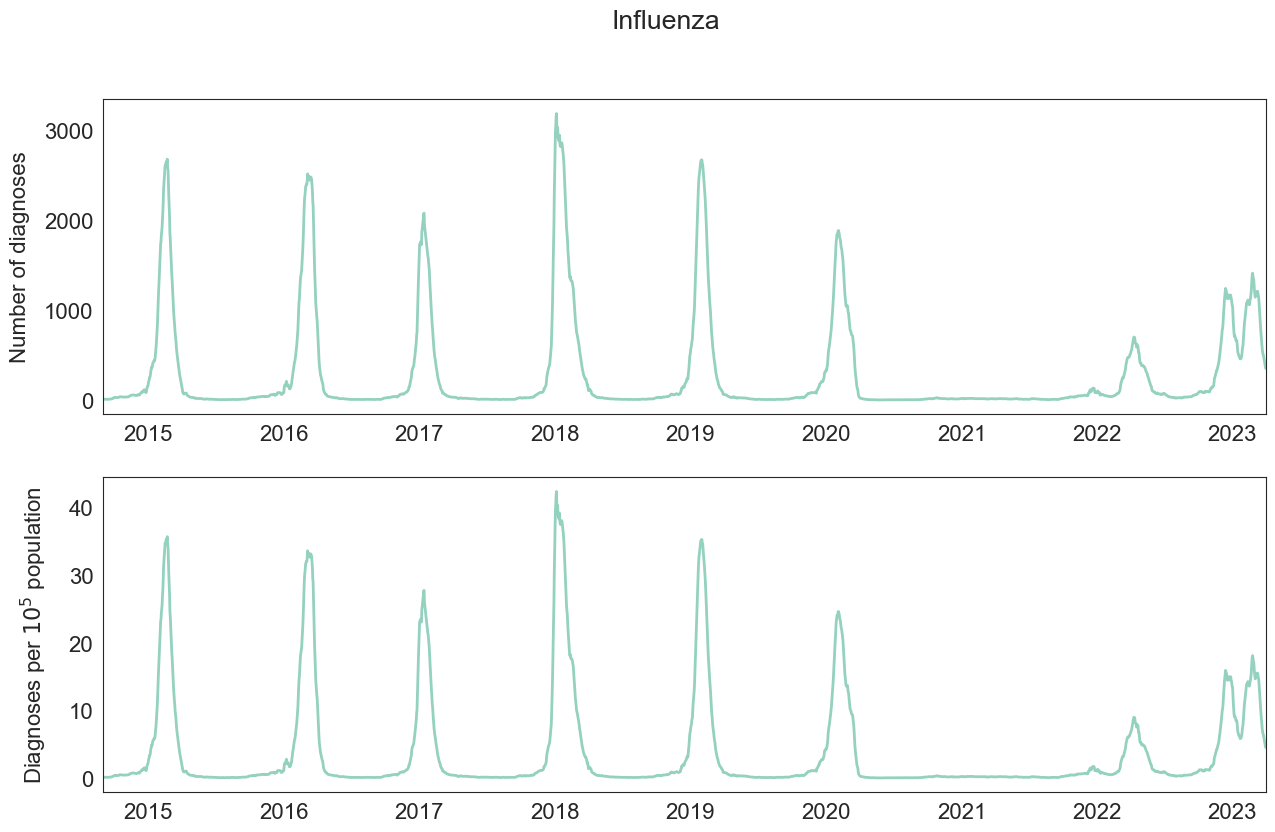

In [102]:
# A plot to see the data we have
sns.set_palette("GnBu_d")
sns.set_style("white")
fig, ax = plt.subplots(2,1,figsize = (15,9))
plt.suptitle('Influenza')
lw = 2
ax[0].plot(cases_of_influenza, linewidth = lw)
ax[0].set_ylabel('Number of diagnoses', labelpad = 10)
ax[1].plot(incidence_of_influenza, linewidth = lw)
ax[1].set_ylabel('Diagnoses per $10^5$ population', labelpad = 15)
ax[0].set_xlim(date(2014,9,1),date(2023,3,31))
ax[1].set_xlim(date(2014,9,1),date(2023,3,31))
#fig.savefig('Influenza_Cases_Inci.png', dpi = 600, bbox_inches = 'tight')

### For bronchiolitis:

In [103]:
# Nowcasting: Percentage of data that is completed in Monday, Tuesday, 
# Wednesday, Thursday, Friday, Saturday, Sunday

sivic_bronchiolitis_weights = [.9432248019, .9434049397, .9439782811, .9559600512, .960441552, .9566436494,
                           .9551982311, .9549707978, .9556914127, .9553607654, .9559256245, .9589265479,
                           .9551774822, .9469215482, .946791272,  .946624672,  .9463667236, .9490766234,
                           .9537227382, .9452696669, .9362236142, .9360084011, .9365032108, .9349173574,
                           .9372312129, .941729455,  .9379280415, .9326110406, .9337047842, .9286070618]

# Obtained weights for the weekly report pattern: Monday, Tuesday, 
# Wednesday, Thursday, Friday, Saturday, Sunday, Holidays
# weekly_report_bronchiolitis_weights = [1.6969697, 1.33, 1.24731868, 1.1725227, 1.27624309,
#                                       0.20588235, 0.15283843, 0.1971831 ]

#weekly_report_bronchiolitis_weights = [1.6945701357466065, 1.2550900680223227, 0.19453118406616593]

In [104]:
# We need to select the cases of children 0 to 2 and join them together
age_groups = [0, '1 i 2']
bronchiolitis_resampled = {}

for age_group in age_groups:
    bronchiolitis_age = bronchiolitis[bronchiolitis.grup_edat == age_group]
    bronchiolitis_resampled[age_group] = preprocess_SIVIC_report(bronchiolitis_age, sivic_bronchiolitis_weights) # Nowcasting approach

bronchiolitis_04 = pd.concat([bronchiolitis_resampled[age_group] for age_group in age_groups], axis=0)
bronchiolitis_04 = bronchiolitis_04[['casos']].resample('D').sum() # sum all cases in one day

# Calculate the rolling mean of the adjusted reported data over a 7-day window
bronchiolitis_cases = bronchiolitis_04.rolling(window=7, center=False, min_periods=1).mean()

# Get the indices of the data points corresponding to the years 2011 and 2012 in the rolling mean data
locs = np.where((bronchiolitis_cases.index.year == 2011) | (bronchiolitis_cases.index.year == 2012))

# Get the 0-4 population in 2012
path_to_population_file = r'C:\Users\A. Perramon Malavez\OneDrive - Universitat Politècnica de Catalunya\Escritorio\BIOCOM-SC\PhD Marató\SISAP\new_population_cat.xlsx'
population_2012 = pd.read_excel(path_to_population_file,sheet_name = '2012')
pop04 = population_2012[(population_2012.Edat == '0') | (population_2012.Edat == '1 i 2')].Total.sum()

# Calculate the incidence of bronchiolitis per 100,000 people for the data points corresponding to the years 2011 and 2012
bronchiolitis_incidence = 1e5*bronchiolitis_cases.iloc[locs[0][0]].div(pop04, fill_value=0)
for j in locs[0][1:]:
    bronchiolitis_incidence = pd.concat([bronchiolitis_incidence,1e5*bronchiolitis_cases.iloc[j].div(pop04, fill_value=0)],ignore_index = True)

# Iterate over the years 2013 through 2023 to calculate the incidence of bronchiolitis per 100,000 people for each year
for yy in np.arange(2013,2024):
    if yy == 2023:
        population_yy = pd.read_excel(path_to_population_file,sheet_name = str(2022))
    else:
        population_yy = pd.read_excel(path_to_population_file,sheet_name = str(yy))
    locs = np.where((bronchiolitis_cases.index.year == yy))
    pop04 = population_yy[(population_yy.Edat == '0') | (population_yy.Edat == '1 i 2')].Total.sum()
    for j in locs[0]:
        bronchiolitis_incidence = pd.concat([bronchiolitis_incidence,1e5*bronchiolitis_cases.iloc[j].div(pop04, fill_value=0)])

# Set the index of the incidence of bronchiolitis per 100,000 people data frame to match the index of the rolling mean report
bronchiolitis_incidence.index = bronchiolitis_cases.index

In [105]:
# We finally take our bronchiolitis data for the period of study:

st = '2014-09-01' # start of the study period
en = '2023-03-31' # end of the study period
cases_of_bronchiolitis = bronchiolitis_cases.loc[st:en]
incidence_of_bronchiolitis = pd.DataFrame(bronchiolitis_incidence.loc[st:en])
incidence_of_bronchiolitis = incidence_of_bronchiolitis.rename(columns={0: 'incidence'})

(16314.0, 19447.0)

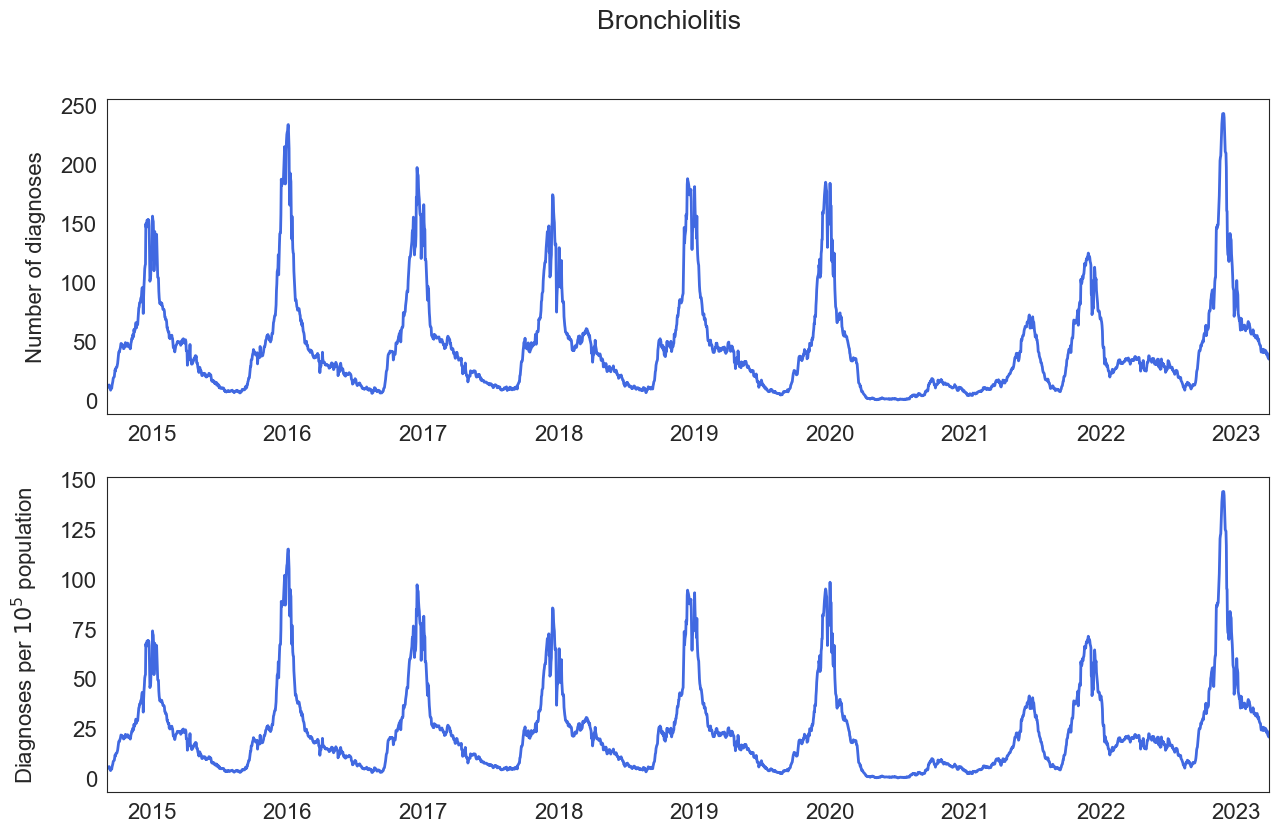

In [106]:
# A plot to see the data we have

fig, ax = plt.subplots(2,1,figsize = (15,9))
plt.suptitle('Bronchiolitis')
ax[0].plot(cases_of_bronchiolitis, color = '#4169E1', linewidth = lw)
ax[0].set_ylabel('Number of diagnoses', labelpad = 10)
ax[1].plot(incidence_of_bronchiolitis, color = '#4169E1', linewidth = lw)
ax[1].set_ylabel('Diagnoses per $10^5$ population', labelpad = 15)
ax[0].set_xlim(date(2014,9,1),date(2023,3,31))
ax[1].set_xlim(date(2014,9,1),date(2023,3,31))
#fig.savefig('Bronchiolitis_Cases_Inci.png', dpi = 600, bbox_inches = 'tight')

## Defining thresholds

We use the EpiLevels code in R to define thresholds for the different levels of an epidemy, per each disease. This code uses weekly incidence, hence we need to resample the incidence with a weekly frequency and save them in an excel in which each row is a season from 2011-2012 to 2019-2020, defining season as september one year to end of august of the following year.

In [107]:
which_latest = max([incidence_of_influenza.index[-1],incidence_of_bronchiolitis.index[-1]])
dayweek = which_latest.weekday()

if dayweek == 0:
    freq = 'W-MON'
if dayweek == 1:
    freq = 'W-TUE'
if dayweek == 2:
    freq = 'W-WED'
if dayweek == 3:
    freq = 'W-THU'
if dayweek == 4:
    freq = 'W-FRI'
if dayweek == 5:
    freq = 'W-SAT'
if dayweek == 6:
    freq = 'W-SUN'

freq = 'W-MON'
weekly_incidence_of_influenza = incidence_of_influenza.resample(freq).sum()
weekly_incidence_of_bronchiolitis = incidence_of_bronchiolitis.resample(freq).sum()
weekly_cases_of_influenza = cases_of_influenza.resample(freq).sum()
weekly_cases_of_bronchiolitis = cases_of_bronchiolitis.resample(freq).sum()

## This was to save data to compute the Thresholds in R

Note that days to use change depending on the day of the week, since the resampling will be made differently.

In [108]:
path_for_weekly_incidences = r"C:\Users\A. Perramon Malavez\OneDrive - Universitat Politècnica de Catalunya\Escritorio\BIOCOM-SC\PhD Marató\SISAP\weekly_incidences_for_EPG.xlsx"

# Define the weekly incidence for each season for influenza
df_influenza = {
    'T1415': weekly_incidence_of_influenza['2014-09-01':'2015-08-24'].incidence.values,
    'T1516': weekly_incidence_of_influenza['2015-09-07':'2016-08-29'].incidence.values,
    'T1617': weekly_incidence_of_influenza['2016-09-05':'2017-08-28'].incidence.values,
    'T1718': weekly_incidence_of_influenza['2017-09-04':'2018-08-27'].incidence.values,
    'T1819': weekly_incidence_of_influenza['2018-09-03':'2019-08-26'].incidence.values,
    'T1920': weekly_incidence_of_influenza['2019-09-02':'2020-08-24'].incidence.values
}

# Define the weekly incidence for each season for bronchiolitis
df_bronchiolitis = {
    'T1415': weekly_incidence_of_bronchiolitis['2014-09-01':'2015-08-24'].incidence.values,
    'T1516': weekly_incidence_of_bronchiolitis['2015-09-07':'2016-08-29'].incidence.values,
    'T1617': weekly_incidence_of_bronchiolitis['2016-09-05':'2017-08-28'].incidence.values,
    'T1718': weekly_incidence_of_bronchiolitis['2017-09-04':'2018-08-27'].incidence.values,
    'T1819': weekly_incidence_of_bronchiolitis['2018-09-03':'2019-08-26'].incidence.values,
    'T1920': weekly_incidence_of_bronchiolitis['2019-09-02':'2020-08-24'].incidence.values
}

# Create dataframes from the dictionaries
df_influenza = pd.DataFrame(df_influenza)
df_bronchiolitis = pd.DataFrame(df_bronchiolitis)

# Write dataframes to an Excel file
with pd.ExcelWriter(path_for_weekly_incidences) as writer:
    df_influenza.to_excel(writer, sheet_name='influenza')
    df_bronchiolitis.to_excel(writer, sheet_name='bronchiolitis')


In [109]:
epi_threshold_influenza = 9
epi_levels_influenza = [21, 53, 138, 214]
# The threshold level is established as the mean incidence during the first day that the incidence 
# of the disease is duplicated per season.
# For influenza, epi_levels are low during the start of the epidemic, medium for the period of growth before the peak,
# high for the average seasons peak, and very high is crossed when we have a very bad season.

In [110]:
epi_threshold_bronchiolitis = 27
epi_levels_bronchiolitis = [89, 141, 250, 453]
# The threshold level is established as the mean incidence during the first day that the incidence 
# of the disease is duplicated per season.
# For bronchiolitis, epi_levels are low during the start of the epidemic while there is still noise, medium for the period of
# stability before the high increase, high for the average seasons growth and peak, and very high is crossed 
# when we have a very bad season.

**Remember: the period between epidemic threshold and low level is basal level.**

The weekly incidence corresponds to the sum of a week of daily incidences, such that we can reconvert our thresholds dividing them by 7 to estimate daily incidence thresholds. 

In [111]:
daily_epi_threshold_influenza = epi_threshold_influenza/7
daily_epi_levels_influenza = [x/7 for x in epi_levels_influenza]
daily_epi_threshold_bronchiolitis = epi_threshold_bronchiolitis/7
daily_epi_levels_bronchiolitis = [x/7 for x in epi_levels_bronchiolitis]

In [112]:
print(daily_epi_threshold_influenza,daily_epi_levels_influenza)

1.2857142857142858 [3.0, 7.571428571428571, 19.714285714285715, 30.571428571428573]


In [113]:
print(daily_epi_threshold_bronchiolitis,daily_epi_levels_bronchiolitis)

3.857142857142857 [12.714285714285714, 20.142857142857142, 35.714285714285715, 64.71428571428571]


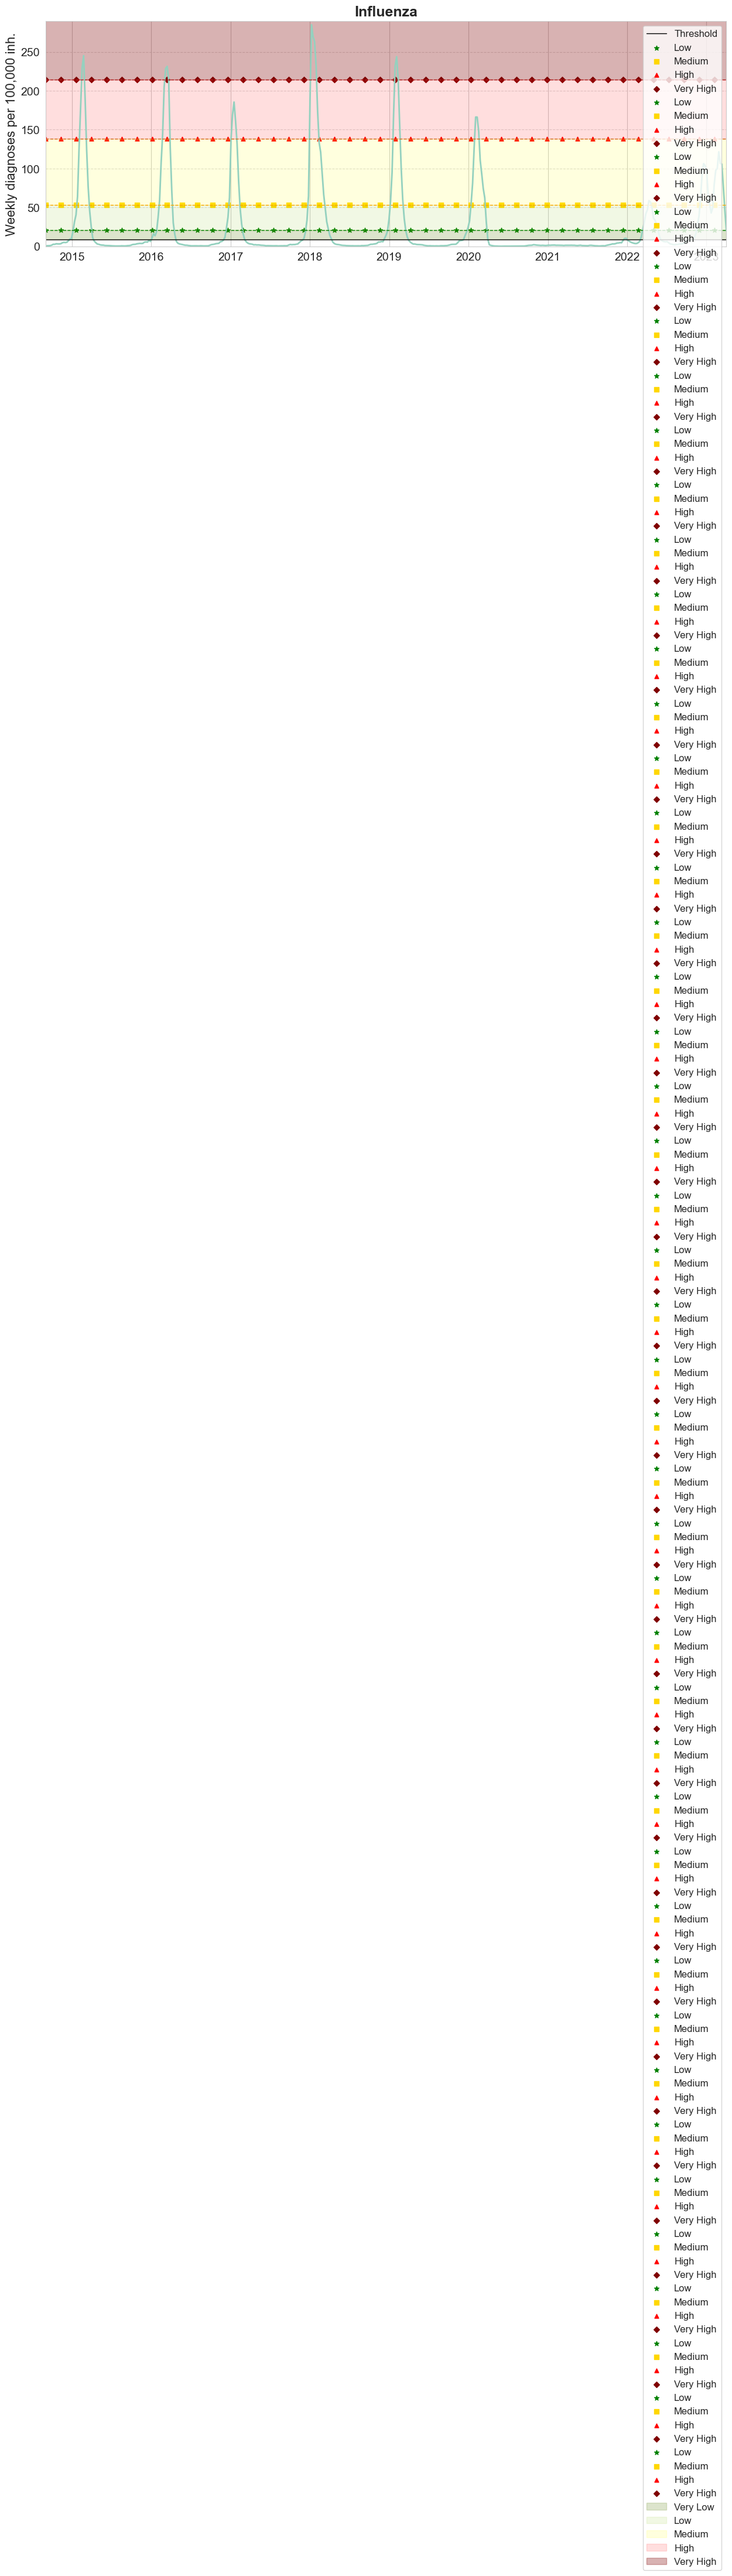

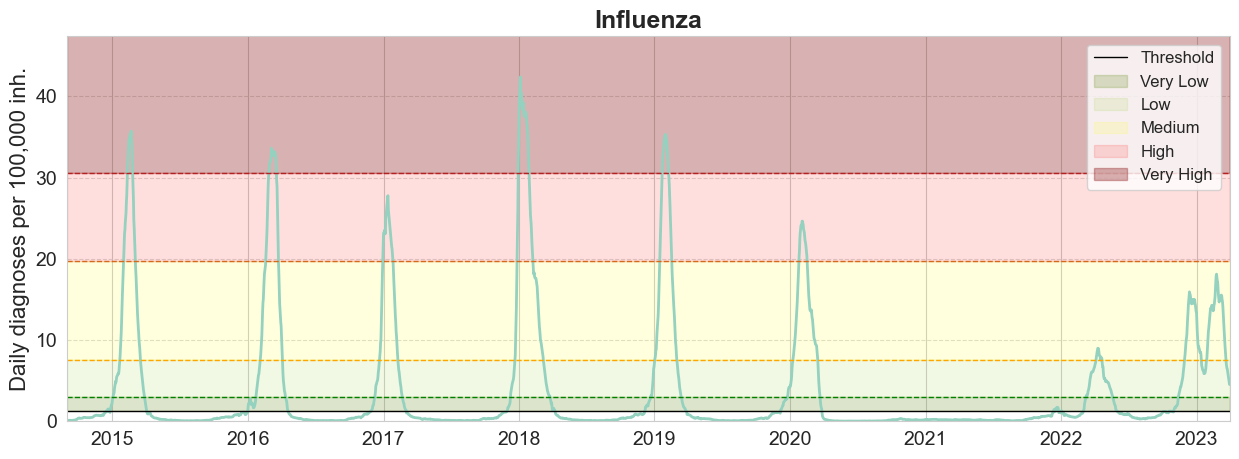

In [114]:
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")

fig, ax = plt.subplots(figsize=(15,5))

# Plot data
plt.plot(weekly_incidence_of_influenza, linewidth=2)

marks = ['*','s','^','D']; selected_indices = list(range(0, len(weekly_incidence_of_influenza), 10))
# Add horizontal lines
ax.axhline(epi_threshold_influenza, color = 'black', linewidth = 1, label = "Threshold")
ax.axhline(epi_levels_influenza[0], color='green', linestyle='--', linewidth=1)
ax.axhline(epi_levels_influenza[1], color='orange', linestyle='--', linewidth=1)
ax.axhline(epi_levels_influenza[2], color='chocolate', linestyle='--', linewidth=1)
ax.axhline(epi_levels_influenza[3], color='firebrick', linestyle='--', linewidth=1)
for idx in selected_indices:
    ax.scatter(weekly_incidence_of_influenza.index[idx], epi_levels_influenza[0],
                   marker=marks[0], color='green', s=35, label = 'Low')
    ax.scatter(weekly_incidence_of_influenza.index[idx], epi_levels_influenza[1],
                   marker=marks[1], color='gold', s=35, label = 'Medium')
    ax.scatter(weekly_incidence_of_influenza.index[idx], epi_levels_influenza[2],
                   marker=marks[2], color='red', s=25, label = "High")
    ax.scatter(weekly_incidence_of_influenza.index[idx], epi_levels_influenza[3],
                   marker=marks[3], color='maroon', s=25, label = "Very High")

ax.fill_between(weekly_incidence_of_influenza.index, epi_threshold_influenza, epi_levels_influenza[0], alpha=0.23, color='olivedrab', label = "Very Low")
ax.fill_between(weekly_incidence_of_influenza.index, epi_levels_influenza[0], epi_levels_influenza[1], alpha=0.13, color='yellowgreen', label = "Low")
ax.fill_between(weekly_incidence_of_influenza.index, epi_levels_influenza[1], epi_levels_influenza[2], alpha=0.13, color='yellow', label = "Medium")
ax.fill_between(weekly_incidence_of_influenza.index, epi_levels_influenza[2], epi_levels_influenza[3], alpha=0.13, color='red', label = "High")
ax.fill_between(weekly_incidence_of_influenza.index, epi_levels_influenza[3], 300,  alpha=0.3, color='maroon', label = "Very High")

ax.set_ylim([0,weekly_incidence_of_influenza.incidence.max()+5])
ax.set_xlim([weekly_incidence_of_influenza.index.min(),weekly_incidence_of_influenza.index.max()])

# Add labels
plt.title('Influenza', fontsize=18, fontweight='bold')
plt.ylabel('Weekly diagnoses per 100,000 inh.', fontsize=16)

# Customize ticks and grid
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Save figure
#plt.savefig('influenza_weekly_incidence.png', dpi=1200, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(15,5))

# Plot data
plt.plot(incidence_of_influenza, linewidth=2)

# Add horizontal lines
ax.axhline(daily_epi_threshold_influenza, color = 'black', linewidth = 1, label = 'Threshold')
ax.axhline(daily_epi_levels_influenza[0], color='green', linestyle='--', linewidth=1)
ax.axhline(daily_epi_levels_influenza[1], color='orange', linestyle='--', linewidth=1)
ax.axhline(daily_epi_levels_influenza[2], color='chocolate', linestyle='--', linewidth=1)
ax.axhline(daily_epi_levels_influenza[3], color='firebrick', linestyle='--', linewidth=1)

ax.fill_between(incidence_of_influenza.index, daily_epi_threshold_influenza, daily_epi_levels_influenza[0], alpha=0.23, color='olivedrab', label = 'Very Low')
ax.fill_between(incidence_of_influenza.index, daily_epi_levels_influenza[0], daily_epi_levels_influenza[1], alpha=0.13, color='yellowgreen', label = 'Low')
ax.fill_between(incidence_of_influenza.index, daily_epi_levels_influenza[1], daily_epi_levels_influenza[2], alpha=0.13, color='yellow', label = 'Medium')
ax.fill_between(incidence_of_influenza.index, daily_epi_levels_influenza[2], daily_epi_levels_influenza[3], alpha=0.13, color='red', label = 'High')
ax.fill_between(incidence_of_influenza.index, daily_epi_levels_influenza[3], 50,  alpha=0.3, color='maroon', label = 'Very High')

ax.set_ylim([0,incidence_of_influenza.incidence.max()+5])
ax.set_xlim([incidence_of_influenza.index.min(),incidence_of_influenza.index.max()])

# Add labels
plt.title('Influenza', fontsize=18, fontweight='bold')
plt.ylabel('Daily diagnoses per 100,000 inh.', fontsize=16)

# Customize ticks and grid
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Save figure
#plt.savefig('influenza_incidence.png', dpi=1200, bbox_inches='tight')



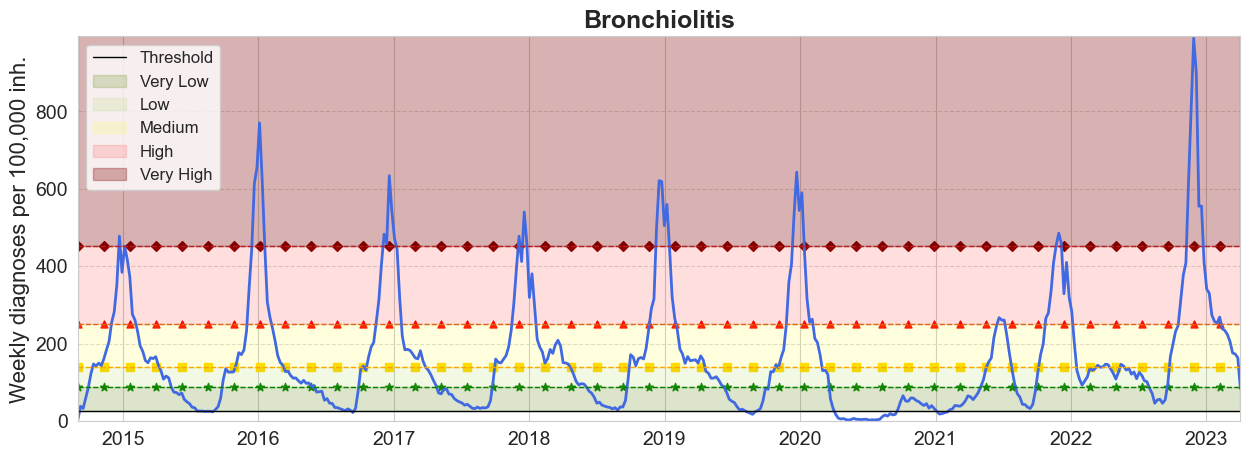

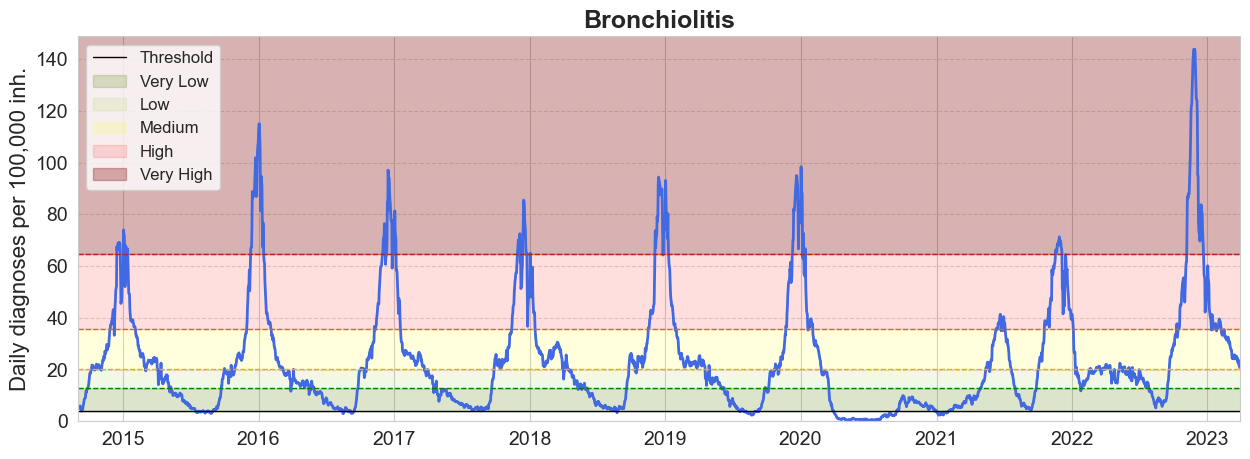

In [115]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(15,5))

# Plot data
plt.plot(weekly_incidence_of_bronchiolitis, linewidth=2, color = '#4169E1')

marks = ['*','s','^','D']; selected_indices = list(range(0, len(weekly_incidence_of_bronchiolitis), 10))
# Add horizontal lines
ax.axhline(epi_threshold_bronchiolitis, color = 'black', linewidth = 1, label = 'Threshold')
ax.axhline(epi_levels_bronchiolitis[0], color='green', linestyle='--', linewidth=1)
for idx in selected_indices:
    ax.scatter(weekly_incidence_of_bronchiolitis.index[idx], epi_levels_bronchiolitis[0],
               marker=marks[0], color='green', s=35)
ax.axhline(epi_levels_bronchiolitis[1], color='orange', linestyle='--', linewidth=1)
for idx in selected_indices:
    ax.scatter(weekly_incidence_of_bronchiolitis.index[idx], epi_levels_bronchiolitis[1],
               marker=marks[1], color='gold', s=35)
ax.axhline(epi_levels_bronchiolitis[2], color='chocolate', linestyle='--', linewidth=1)
for idx in selected_indices:
    ax.scatter(weekly_incidence_of_bronchiolitis.index[idx], epi_levels_bronchiolitis[2],
               marker=marks[2], color='red', s=25)
ax.axhline(epi_levels_bronchiolitis[3], color='firebrick', linestyle='--', linewidth=1)
for idx in selected_indices:
    ax.scatter(weekly_incidence_of_bronchiolitis.index[idx], epi_levels_bronchiolitis[3],
               marker=marks[3], color='maroon', s=25)

ax.fill_between(weekly_incidence_of_bronchiolitis.index, epi_threshold_bronchiolitis, epi_levels_bronchiolitis[0], alpha=0.23, color='olivedrab', label = 'Very Low')
ax.fill_between(weekly_incidence_of_bronchiolitis.index, epi_levels_bronchiolitis[0], epi_levels_bronchiolitis[1], alpha=0.13, color='yellowgreen', label = 'Low')
ax.fill_between(weekly_incidence_of_bronchiolitis.index, epi_levels_bronchiolitis[1], epi_levels_bronchiolitis[2], alpha=0.13, color='yellow', label = 'Medium')
ax.fill_between(weekly_incidence_of_bronchiolitis.index, epi_levels_bronchiolitis[2], epi_levels_bronchiolitis[3], alpha=0.13, color='red', label = 'High')
ax.fill_between(weekly_incidence_of_bronchiolitis.index, epi_levels_bronchiolitis[3], 1000,  alpha=0.3, color='maroon', label = 'Very High')

ax.set_ylim([0,weekly_incidence_of_bronchiolitis.incidence.max()+5])
ax.set_xlim([weekly_incidence_of_bronchiolitis.index.min(),weekly_incidence_of_bronchiolitis.index.max()])

# Add labels
plt.title('Bronchiolitis', fontsize=18, fontweight='bold')
plt.ylabel('Weekly diagnoses per 100,000 inh.', fontsize=16)

# Customize ticks and grid
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc='upper left', fontsize=12)

# Save figure
plt.savefig('bronchiolitis_weekly_incidence.png', dpi=1200, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(15,5))

# Plot data
plt.plot(incidence_of_bronchiolitis, linewidth=2, color = '#4169E1')

# Add horizontal lines
ax.axhline(daily_epi_threshold_bronchiolitis, color = 'black', linewidth = 1, label = 'Threshold')
ax.axhline(daily_epi_levels_bronchiolitis[0], color='green', linestyle='--', linewidth=1)
ax.axhline(daily_epi_levels_bronchiolitis[1], color='orange', linestyle='--', linewidth=1)
ax.axhline(daily_epi_levels_bronchiolitis[2], color='chocolate', linestyle='--', linewidth=1)
ax.axhline(daily_epi_levels_bronchiolitis[3], color='firebrick', linestyle='--', linewidth=1)

ax.fill_between(incidence_of_bronchiolitis.index, daily_epi_threshold_bronchiolitis, daily_epi_levels_bronchiolitis[0], alpha=0.23, color='olivedrab', label = 'Very Low')
ax.fill_between(incidence_of_bronchiolitis.index, daily_epi_levels_bronchiolitis[0], daily_epi_levels_bronchiolitis[1], alpha=0.13, color='yellowgreen', label = 'Low')
ax.fill_between(incidence_of_bronchiolitis.index, daily_epi_levels_bronchiolitis[1], daily_epi_levels_bronchiolitis[2], alpha=0.13, color='yellow', label = 'Medium')
ax.fill_between(incidence_of_bronchiolitis.index, daily_epi_levels_bronchiolitis[2], daily_epi_levels_bronchiolitis[3], alpha=0.13, color='red', label = 'High')
ax.fill_between(incidence_of_bronchiolitis.index, daily_epi_levels_bronchiolitis[3], 150,  alpha=0.3, color='maroon', label = 'Very High')

ax.set_ylim([0,incidence_of_bronchiolitis.incidence.max()+5])
ax.set_xlim([incidence_of_bronchiolitis.index.min(),incidence_of_bronchiolitis.index.max()])
# Add labels
plt.title('Bronchiolitis', fontsize=18, fontweight='bold')
plt.ylabel('Daily diagnoses per 100,000 inh.', fontsize=16)

# Customize ticks and grid
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc='upper left', fontsize=12)

# Save figure
#plt.savefig('bronchiolitis_incidence.png', dpi=1200, bbox_inches='tight')



## EPG and Risk Diagrams

In [116]:
t = 5;
Tau = 7;

EPG_bronchiolitis = [0]*len(cases_of_bronchiolitis); A7_bronchiolitis = [0]*len(cases_of_bronchiolitis); rho5_bronchiolitis = [0]*len(cases_of_bronchiolitis); rho5_bronchiolitis_alone = [0]*len(cases_of_bronchiolitis);
for i in range(6,len(cases_of_bronchiolitis)-1):
    rho5_bronchiolitis_alone[i] = (cases_of_bronchiolitis.casos.iloc[i]+cases_of_bronchiolitis.casos.iloc[i-1]+cases_of_bronchiolitis.casos.iloc[i+1])/(cases_of_bronchiolitis.casos.iloc[i-t-1]+cases_of_bronchiolitis.casos.iloc[i-t]+cases_of_bronchiolitis.casos.iloc[i-t+1])
    rho5_bronchiolitis[i] = ((cases_of_bronchiolitis.casos.iloc[i]+cases_of_bronchiolitis.casos.iloc[i-1]+cases_of_bronchiolitis.casos.iloc[i+1])/(cases_of_bronchiolitis.casos.iloc[i-t-1]+cases_of_bronchiolitis.casos.iloc[i-t]+cases_of_bronchiolitis.casos.iloc[i-t+1]))**(Tau/t)
    A7_bronchiolitis[i] = incidence_of_bronchiolitis.incidence.iloc[i-6:i+1].sum()
    EPG_bronchiolitis[i] = A7_bronchiolitis[i]*rho5_bronchiolitis[i]

A7_bronchiolitis_df = pd.DataFrame({'A7_bronchiolitis':A7_bronchiolitis}, index = incidence_of_bronchiolitis.index)
rho5_bronchiolitis_alone_df = pd.DataFrame({'rho5_bronchiolitis':rho5_bronchiolitis_alone}, index = incidence_of_bronchiolitis.index)
rho5_bronchiolitis_alone_df = rho5_bronchiolitis_alone_df.rolling(window=7, center=True, min_periods=1).mean()
rho5_bronchiolitis_df = pd.DataFrame({'rho5_bronchiolitis':rho5_bronchiolitis}, index = incidence_of_bronchiolitis.index)
rho5_bronchiolitis_df = rho5_bronchiolitis_df.rolling(window=7, center=True, min_periods=1).mean()
EPG_bronchiolitis_df = np.multiply(A7_bronchiolitis_df,rho5_bronchiolitis_df)


EPG_influenza = [0]*len(cases_of_influenza); A7_influenza = [0]*len(cases_of_influenza); rho5_influenza = [0]*len(cases_of_influenza); rho5_influenza_alone = [0]*len(cases_of_influenza); 
for i in range(6,len(cases_of_influenza)-1):
    rho5_influenza_alone[i] = (cases_of_influenza.casos.iloc[i]+cases_of_influenza.casos.iloc[i-1]+cases_of_influenza.casos.iloc[i+1])/(cases_of_influenza.casos.iloc[i-t-1]+cases_of_influenza.casos.iloc[i-t]+cases_of_influenza.casos.iloc[i-t+1])
    rho5_influenza[i] = ((cases_of_influenza.casos.iloc[i]+cases_of_influenza.casos.iloc[i-1]+cases_of_influenza.casos.iloc[i+1])/(cases_of_influenza.casos.iloc[i-t-1]+cases_of_influenza.casos.iloc[i-t]+cases_of_influenza.casos.iloc[i-t+1]))**(Tau/t)
    A7_influenza[i] = incidence_of_influenza.incidence.iloc[i-6:i+1].sum()
    EPG_influenza[i] = A7_influenza[i]*rho5_influenza[i]

A7_influenza_df = pd.DataFrame({'A7_influenza':A7_influenza}, index = incidence_of_influenza.index)
rho5_influenza_alone_df = pd.DataFrame({'rho5_influenza':rho5_influenza_alone}, index = incidence_of_influenza.index)
rho5_influenza_alone_df = rho5_influenza_alone_df.rolling(window=7, center=True, min_periods=1).mean()
rho5_influenza_df = pd.DataFrame({'rho5_influenza':rho5_influenza}, index = incidence_of_influenza.index)
rho5_influenza_df = rho5_influenza_df.rolling(window=7, center=True, min_periods=1).mean()
EPG_influenza_df = np.multiply(A7_influenza_df,rho5_influenza_df)

    

C:\Users\A. Perramon Malavez\AppData\Local\Temp\ipykernel_37244\4228997280.py:16: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  EPG_bronchiolitis_df = np.multiply(A7_bronchiolitis_df,rho5_bronchiolitis_df)
C:\Users\A. Perramon Malavez\AppData\Local\Temp\ipykernel_37244\4228997280.py:31: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be al

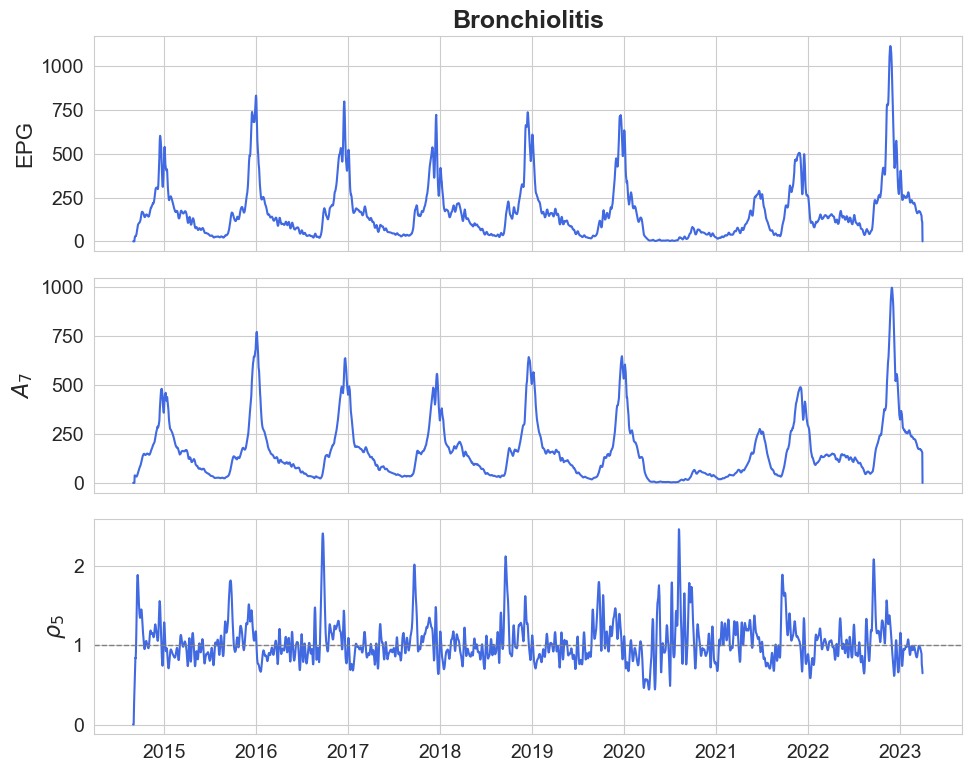

In [117]:
sns.set_palette("pastel")
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
ax1.set_title('Bronchiolitis', fontsize=18, fontweight='bold')

ax1.plot(EPG_bronchiolitis_df, color = '#4169E1')
ax1.set_ylabel('EPG', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax1.set_xticklabels([])  # remove xticklabels

ax2.plot(A7_bronchiolitis_df, color = '#4169E1')
ax2.set_ylabel('$A_7$', fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_xticklabels([])  # remove xticklabels

ax3.plot(rho5_bronchiolitis_df, color = '#4169E1')
#ax3.set_xlabel('Week', fontsize=16)
ax3.set_ylabel(r'$\rho_{5}$', fontsize=16)
ax3.tick_params(axis='both', labelsize=14)
ax3.axhline(1, color = '#808080', linestyle = '--', linewidth = 1)

plt.tight_layout()
#plt.savefig('bronchiolitis_EPG_decomposed.png', dpi=1200, bbox_inches='tight')

plt.show()


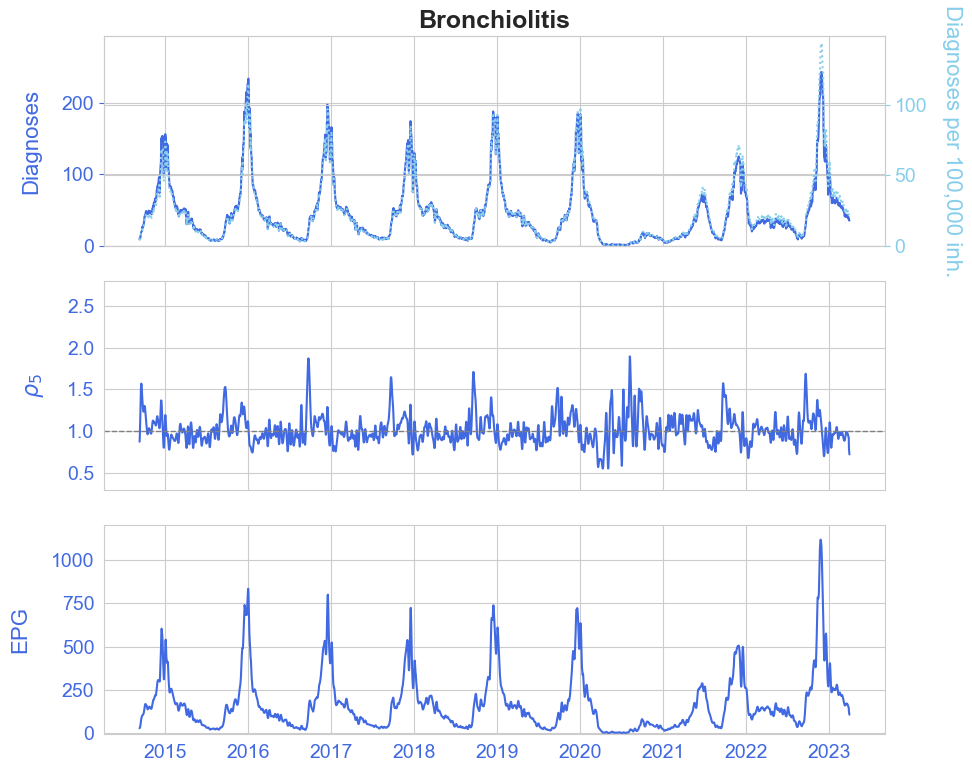

In [118]:
sns.set_palette("pastel")
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
ax1.set_title('Bronchiolitis', fontsize=18, fontweight='bold')

ax1.plot(cases_of_bronchiolitis.iloc[10:-1], color = '#4169E1')
ax12 = ax1.twinx()
ax12.plot(incidence_of_bronchiolitis.iloc[10:-1], ':', color = '#87CEEB')
ax1.set_ylabel('Diagnoses', fontsize=16, labelpad = 15, color = '#4169E1')
ax12.set_ylabel('Diagnoses per 100,000 inh.', fontsize=16, rotation = 270, labelpad = 25, color = 'skyblue')
ax1.tick_params(axis='both', labelsize=14, colors = '#4169E1')
ax12.tick_params(axis='both', labelsize=14, colors = '#87CEEB')
ax1.set_xticklabels([])  # remove xticklabels
ax1.set_ylim([0, np.max(cases_of_bronchiolitis.values)+50])
ax12.set_ylim([0, np.max(incidence_of_bronchiolitis.values)+5])

ax2.plot(rho5_bronchiolitis_alone_df.iloc[10:-1], color = '#4169E1')
#ax22 = ax2.twinx()
#ax22.plot(rho5_bronchiolitis_scaled_df.iloc[10:-1], ':', color = '#87CEEB')
ax2.set_ylabel(r'$\rho_{5}$', fontsize=16, labelpad = 15, color = '#4169E1')
#ax22.set_ylabel(r'Corrected $\rho_{5}$', fontsize=16, rotation = 270, labelpad = 30, color = '#87CEEB')
#ax22.tick_params(axis='both', labelsize=14, colors = '#87CEEB')
ax2.tick_params(axis='both', labelsize=14, colors = '#4169E1')
ax2.set_xticklabels([])  # remove xticklabels
ax2.axhline(1, color = '#808080', linestyle = '--', linewidth = 1)
ax2.set_ylim((0.3,2.8)); #ax22.set_ylim((0.3,2.8))

ax3.plot(EPG_bronchiolitis_df.iloc[10:-1], color = '#4169E1')
#ax32 = ax3.twinx()
#ax32.plot(EPG_bronchiolitis_scaled_df.iloc[10:-1], ':', color = '#87CEEB')
ax3.set_ylabel('EPG', fontsize=16, labelpad = 15, color = '#4169E1')
#ax32.set_ylabel('Corrected EPG', fontsize=16, rotation = 270, labelpad = 15, color = '#87CEEB')
#ax32.tick_params(axis='both', labelsize=14, colors = '#87CEEB')
ax3.tick_params(axis='both', labelsize=14, colors = '#4169E1')
ax3.set_ylim([0, np.max(EPG_bronchiolitis)+50])
ax3.set_ylim((-5,1200)); #ax32.set_ylim((-5,1200))

plt.tight_layout()
#plt.savefig('bronchiolitis_EPG_decomposed_vf5.png', dpi=1200, bbox_inches='tight')

plt.show()

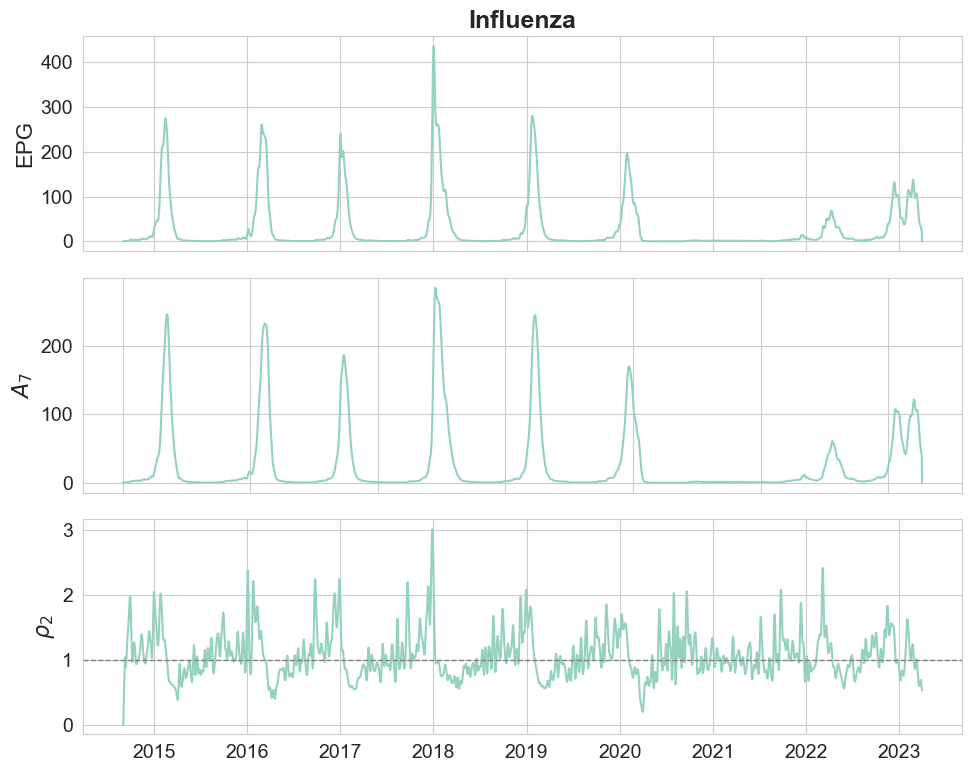

In [119]:
sns.set_palette("GnBu_d")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
ax1.set_title('Influenza', fontsize=18, fontweight='bold')

ax1.plot(EPG_influenza_df)
ax1.set_ylabel('EPG', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax1.set_xticklabels([])  # remove xticklabels

ax2.plot(A7_influenza)
ax2.set_ylabel('$A_7$', fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_xticklabels([])  # remove xticklabels

ax3.plot(rho5_influenza_df)
#ax3.set_xlabel('Week', fontsize=16)
ax3.set_ylabel(r'$\rho_{2}$', fontsize=16)
ax3.tick_params(axis='both', labelsize=14)
ax3.axhline(1, color = '#808080', linestyle = '--', linewidth = 1)

plt.tight_layout()
#plt.savefig('influenza_EPG_decomposed.png', dpi=1200, bbox_inches='tight')
plt.show()

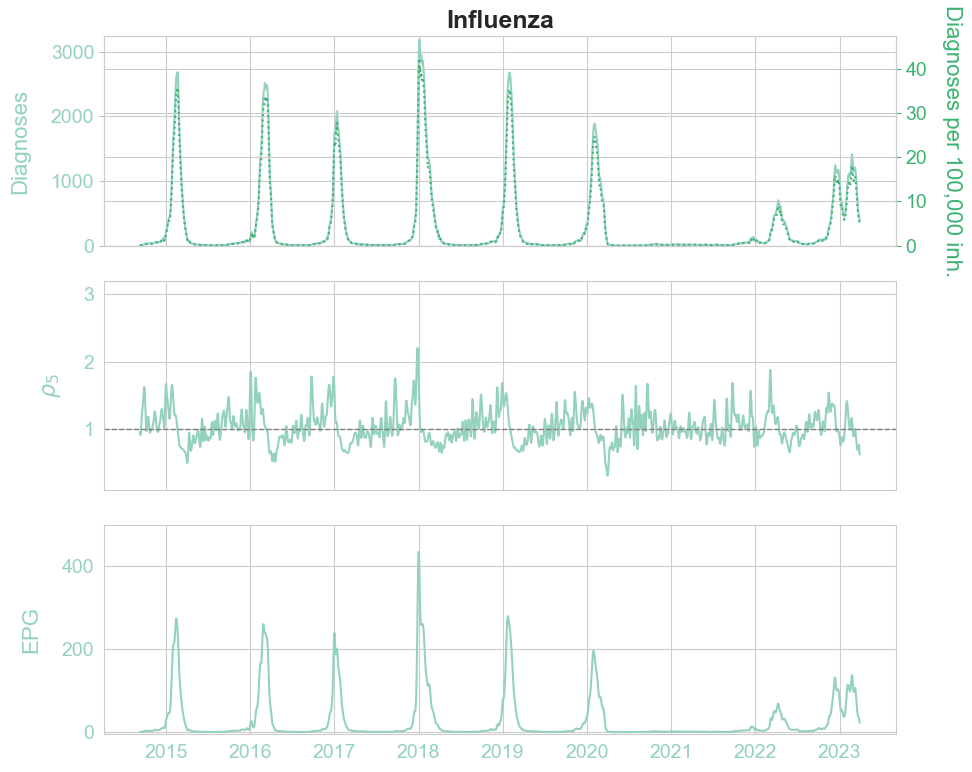

In [120]:
sns.set_palette("GnBu_d")
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
ax1.set_title('Influenza', fontsize=18, fontweight='bold')

# Use a slightly darker green color for labels
green_color = sns.color_palette("GnBu_d")[0]  # Choose a different shade from the palette

ax1.plot(cases_of_influenza.iloc[10:-1], color = green_color)
ax12 = ax1.twinx()
ax12.plot(incidence_of_influenza.iloc[10:-1], ':', color = 'mediumseagreen')
ax1.set_ylabel('Diagnoses', fontsize=16, labelpad = 15, color = green_color)
ax12.set_ylabel('Diagnoses per 100,000 inh.', fontsize=16, rotation = 270, labelpad = 25, color = 'mediumseagreen')
ax1.tick_params(axis='both', labelsize=14, colors = green_color)
ax12.tick_params(axis='both', labelsize=14, colors = 'mediumseagreen')
ax1.set_xticklabels([])  # remove xticklabels
ax1.set_ylim([0, np.max(cases_of_influenza.values)+50])
ax12.set_ylim([0, np.max(incidence_of_influenza.values)+5])

ax2.plot(rho5_influenza_alone_df.iloc[10:-1], color = green_color)
#ax22 = ax2.twinx()
#ax22.plot(rho5_influenza_scaled_df.iloc[10:-1], ':', color = 'mediumseagreen')
ax2.set_ylabel(r'$\rho_{5}$', fontsize=16, labelpad = 15, color = green_color)
#ax22.set_ylabel(r'Corrected $\rho_{5}$', fontsize=16, rotation = 270, labelpad = 15, color = 'mediumseagreen')
#ax22.tick_params(axis='both', labelsize=14, colors = 'mediumseagreen')
ax2.tick_params(axis='both', labelsize=14, colors = green_color)
ax2.set_xticklabels([])  # remove xticklabels
ax2.axhline(1, color = '#808080', linestyle = '--', linewidth = 1)
ax2.set_ylim((0.1,3.2)); #ax22.set_ylim((0.1,3.2))

ax3.plot(EPG_influenza_df.iloc[10:-1], color = green_color)
#ax32 = ax3.twinx()
#ax32.plot(EPG_influenza_scaled_df.iloc[10:-1], ':', color = 'mediumseagreen')
ax3.set_ylabel('EPG', fontsize=16, labelpad = 15, color = green_color)
#ax32.set_ylabel('Corrected EPG', fontsize=16, rotation = 270, labelpad = 15, color = 'mediumseagreen')
#ax32.tick_params(axis='both', labelsize=14, colors = 'mediumseagreen')
ax3.tick_params(axis='both', labelsize=14, colors = green_color)
ax3.set_ylim((-5,500)); #ax32.set_ylim((-5,500))

plt.tight_layout()
#plt.savefig('influenza_EPG_decomposed_vf5.png', dpi=1200, bbox_inches='tight')

plt.show()


In [121]:
when_2018 = np.where(cases_of_influenza.index == "2018-09-01")
print(when_2018)
when_2019 = np.where(cases_of_influenza.index == "2019-09-01")
print(when_2019)

(array([1461], dtype=int64),)
(array([1826], dtype=int64),)


In [122]:
start_influ = np.where(np.array(A7_influenza[2557:2922]) >= epi_threshold_influenza)
start_bronchi = np.where(np.array(A7_bronchiolitis[2557:2922]) >= epi_threshold_bronchiolitis)

print(start_influ[0][0],start_bronchi[0][0])

107 0


In [123]:
print(len(A7_bronchiolitis[0:366]))
print(len(A7_bronchiolitis[366:731]))
print(len(A7_bronchiolitis[731:1096]))
print(len(A7_bronchiolitis[4018:4228]))

366
365
365
0


In [124]:
# Split the bronchiolitis time series into seasons or years
slice_lengths = [365, 366, 365, 365, 365, 366, 365, 365, 210]  # Adjust the lengths as needed

# Initialize the epg_influenza_plot array with the correct shape
epg_bronchiolitis_plot = np.empty((len(slice_lengths), max(slice_lengths)))

# Fill the epg_influenza_plot array with the slices
start_idx = 0
for i, length in enumerate(slice_lengths):
    epg_bronchiolitis_plot[i, :length] = EPG_bronchiolitis_df.A7_bronchiolitis.iloc[start_idx:start_idx + length].values
    start_idx += length

# Initialize the seasons_bronchiolitis array with the correct shape
seasons_bronchiolitis = np.empty((len(slice_lengths), max(slice_lengths)))

# Fill the seasons_bronchiolitis array with the slices
start_idx = 0
for i, length in enumerate(slice_lengths):
    seasons_bronchiolitis[i, :length] = A7_bronchiolitis[start_idx:start_idx + length]
    start_idx += length

# Initialize the seasons_bronchiolitis array with the correct shape
rho5_bronchiolitis = rho5_bronchiolitis_df.rho5_bronchiolitis
rho5_seasons_bronchiolitis = np.empty((len(slice_lengths), max(slice_lengths)))

# Fill the rho5_seasons_bronchiolitis array with the slices
start_idx = 0
for i, length in enumerate(slice_lengths):
    rho5_seasons_bronchiolitis[i, :length] = rho5_bronchiolitis[start_idx:start_idx + length]
    start_idx += length

# Initialize the epg_influenza_plot array with the correct shape
epg_influenza_plot = np.empty((len(slice_lengths), max(slice_lengths)))

# Fill the epg_influenza_plot array with the slices
start_idx = 0
for i, length in enumerate(slice_lengths):
    epg_influenza_plot[i, :length] = EPG_influenza_df.A7_influenza.iloc[start_idx:start_idx + length].values
    start_idx += length
    
seasons_influenza = np.empty((len(slice_lengths), max(slice_lengths)))
# Fill the seasons_influenza array with the slices
start_idx = 0
for i, length in enumerate(slice_lengths):
    seasons_influenza[i, :length] = A7_influenza[start_idx:start_idx + length]
    start_idx += length

rho5_seasons_influenza = np.empty((len(slice_lengths), max(slice_lengths)))

# Fill the rho5_seasons_influenza array with the slices
start_idx = 0
for i, length in enumerate(slice_lengths):
    rho5_seasons_influenza[i, :length] = rho5_influenza[start_idx:start_idx + length]
    start_idx += length

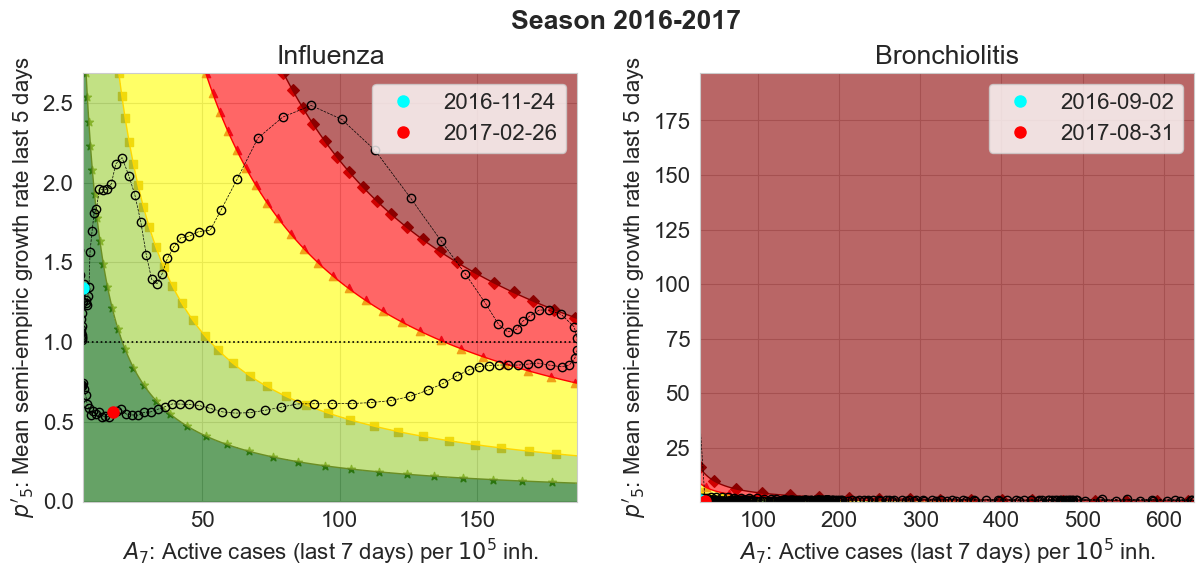

In [130]:

# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
fig.tight_layout(pad=3.0)

st = "2014-09-01"; en = "2015-09-01"
x = pd.date_range(start=st,end=en, freq='D')

# Set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

colors = ['darkgreen', 'yellowgreen', 'yellow', 'red', 'darkred']
cols = ['olivedrab', 'gold', 'red', 'darkred']
mark_col = ['olivedrab', 'goldenrod', 'crimson', 'darkred']
marks = ['*','s','^','D']
custom_cmap = ListedColormap(colors)

# Define boundaries for each color
boundaries_inf = [epi_threshold_influenza, epi_levels_influenza[0], epi_levels_influenza[1], epi_levels_influenza[2], epi_levels_influenza[3], np.inf]
# Create a BoundaryNorm
norm_inf = BoundaryNorm(boundaries_inf, len(colors))

param = 0 # arreglar 20-21 que és param 6

# Plot Influenza data
a7 = np.linspace(np.min(seasons_influenza[param]), np.max(seasons_influenza[param]), 500)
rh = np.linspace(np.min(rho5_seasons_influenza[param]), np.max(rho5_seasons_influenza[param]), 500)
A7, RH = np.meshgrid(a7, rh)
EPG = A7 * RH

for ii, threshold in enumerate(epi_levels_influenza):
    #ax[0].contour(A7, RH, EPG, levels=[threshold], colors=cols[ii], linewidths=2)
    # Assuming you have already extracted the contour lines and paths
    contour_lines = ax[0].contour(A7, RH, EPG, levels=[threshold], colors=cols[ii], linewidths=1)
    paths = contour_lines.collections[0].get_paths()

    # Extracting vertices from paths
    for path in paths:
        vertices = path.vertices
        subsampled_vertices = vertices[::30]  # Subsample every 10th vertex
        # Scatter diamonds at the vertices
        ax[0].scatter(subsampled_vertices[:, 0], subsampled_vertices[:, 1], marker=marks[ii], color=mark_col[ii], s=35)

ax[0].pcolormesh(A7, RH, EPG, cmap=custom_cmap, alpha=0.6, shading='auto', norm=norm_inf)

ax[0].plot(seasons_influenza[param], rho5_seasons_influenza[param], 'ko--', fillstyle='none', linewidth=0.5)
ax[0].set_ylabel(r"$p'_5$: Mean semi-empiric growth rate last 5 days", fontsize=16)
ax[0].set_xlabel(r'$A_7$: Active cases (last 7 days) per $10^5$ inh.', fontsize=16)

threshold_index_influ = np.where(np.array(rho5_seasons_influenza[param])*np.array(seasons_influenza[param]) >= epi_threshold_influenza)
ax[0].set_xlim([seasons_influenza[param][threshold_index_influ[0][0]], np.max(seasons_influenza[param])])


# Define boundaries for each color
boundaries_bronq = [epi_threshold_bronchiolitis, epi_levels_bronchiolitis[0], epi_levels_bronchiolitis[1], epi_levels_bronchiolitis[2], epi_levels_bronchiolitis[3], np.inf]
# Create a BoundaryNorm
norm_bronq = BoundaryNorm(boundaries_bronq, len(colors))

# Plot Bronchiolitis data
a7 = np.linspace(np.min(seasons_bronchiolitis[param]), np.max(seasons_bronchiolitis[param]), 500)
rh = np.linspace(np.min(rho5_seasons_bronchiolitis[param]), np.max(rho5_seasons_bronchiolitis[param]), 500)
A7, RH = np.meshgrid(a7, rh)
EPG = A7 * RH


for ii, threshold in enumerate(epi_levels_bronchiolitis):
    #ax[0].contour(A7, RH, EPG, levels=[threshold], colors=cols[ii], linewidths=2)
    # Assuming you have already extracted the contour lines and paths
    contour_lines = ax[1].contour(A7, RH, EPG, levels=[threshold], colors=cols[ii], linewidths=1)
    paths = contour_lines.collections[0].get_paths()

    # Extracting vertices from paths
    for path in paths:
        vertices = path.vertices
        subsampled_vertices = vertices[::30]  # Subsample every 10th vertex
        # Scatter diamonds at the vertices
        ax[1].scatter(subsampled_vertices[:, 0], subsampled_vertices[:, 1], marker=marks[ii], color=mark_col[ii], s=35)

ax[1].pcolormesh(A7, RH, EPG, cmap=custom_cmap, alpha=0.6, shading='auto', norm=norm_bronq)

ax[1].plot(seasons_bronchiolitis[param], rho5_seasons_bronchiolitis[param], 'ko--', fillstyle='none', linewidth=0.5)
ax[1].set_ylabel(r"$p'_5$: Mean semi-empiric growth rate last 5 days", fontsize=16)
ax[1].set_xlabel(r'$A_7$: Active cases (last 7 days) per $10^5$ inh.', fontsize=16)

threshold_index_bronchi = np.where(np.array(rho5_seasons_bronchiolitis[param])*np.array(seasons_bronchiolitis[param]) >= epi_threshold_bronchiolitis)
ax[1].set_xlim([seasons_bronchiolitis[param][threshold_index_bronchi[0][0]], np.max(seasons_bronchiolitis[param])])

plt.suptitle('Season 2014-2015', fontweight = 'bold')
ax[0].set_title('Influenza')
ax[1].set_title('Bronchiolitis')
ax[0].axhline(1,color = 'black',linestyle = ':', linewidth = 1.2)
ax[1].axhline(1,color = 'black',linestyle = ':', linewidth = 1.2)

ax[0].plot(seasons_influenza[param][threshold_index_influ[0][0]], rho5_seasons_influenza[param][threshold_index_influ[0][0]],'o', color = '#00FFFF', markersize = 8, label = x[threshold_index_influ[0][0]].date())
ax[0].plot(seasons_influenza[param][threshold_index_influ[0][-1]], rho5_seasons_influenza[param][threshold_index_influ[0][-1]],'ro', markersize = 8, label = x[threshold_index_influ[0][-1]].date())

ax[1].plot(seasons_bronchiolitis[param][threshold_index_bronchi[0][0]], rho5_seasons_bronchiolitis[param][threshold_index_bronchi[0][0]],'o', color = '#00FFFF', markersize = 8, label = x[threshold_index_bronchi[0][0]].date())
ax[1].plot(seasons_bronchiolitis[param][threshold_index_bronchi[0][-1]], rho5_seasons_bronchiolitis[param][threshold_index_bronchi[0][-1]],'ro', markersize = 8, label = x[threshold_index_bronchi[0][-1]].date())

ax[0].legend()
ax[1].legend()

#plt.savefig('risk_diagram_season1415.png', dpi=1200, bbox_inches='tight')
plt.show()

In [126]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

## Assessment of EPG as indicator

In [ ]:
# Perform lagged correlation analysis for bronchiolitis
corr_bronchiolitis = []
lags_bronchiolitis = range(-14, 15)
for lag in lags_bronchiolitis:
    corr_bronchiolitis.append(np.corrcoef(np.roll(A7_bronchiolitis, shift=lag), EPG_bronchiolitis)[0,1])
maxcorr_bronchiolitis = max(corr_bronchiolitis)
maxlag_bronchiolitis = lags_bronchiolitis[np.argmax(corr_bronchiolitis)]
print('Max correlation value for bronchiolitis:', maxcorr_bronchiolitis)
print('Max correlation lag for bronchiolitis:', maxlag_bronchiolitis)

# Perform lagged correlation analysis for influenza
corr_influenza = []
lags_influenza = range(-14, 15)
for lag in lags_influenza:
    corr_influenza.append(np.corrcoef(np.roll(A7_influenza, shift=lag), EPG_influenza)[0,1])
maxcorr_influenza = max(corr_influenza)
maxlag_influenza = lags_influenza[np.argmax(corr_influenza)]
print('Max correlation value for influenza:', maxcorr_influenza)
print('Max correlation lag for influenza:', maxlag_influenza)

In [ ]:
# Define the number of seasons or years you have
n_seasons = 9

epg_seasons_bronchiolitis = epg_bronchiolitis_plot
#np.array_split(EPG_bronchiolitis, n_seasons)

fig,ax = plt.subplots(n_seasons,2, figsize = (20,105))
plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 18
# Loop over each season or year of bronchiolitis data and calculate the lagged correlation
figs,axs = plt.subplots(figsize = (10,5))
cmap = plt.cm.get_cmap('Paired',n_seasons)
for i in range(n_seasons):
    season_start_date = datetime(2014+i,9,1)
    season_end_date = datetime(2015+i,8,31)
    if i==9:
        season_end_date = datetime(2023,3,30)
        fig2,ax2 = plt.subplots(1,2, figsize = (20,5))
        xticksp = pd.date_range(season_start_date, season_end_date, freq='D')
        xticks = pd.date_range(season_start_date, season_end_date, freq='M')
        xticklabels = [datetime.strftime(date, '%b-%Y') for date in xticks]
        for lag in lags_bronchiolitis:
            ax2[0].plot(xticksp,np.roll(seasons_bronchiolitis[i], shift=lag), linestyle = '--', color = 'oldlace')
        ax2[0].plot(xticksp, seasons_bronchiolitis[i], color = 'burlywood', label = '$A_7$', linewidth = 2)
        ax2[0].plot(xticksp, epg_seasons_bronchiolitis[i], color = 'mediumpurple', alpha = .7, label = 'EPG', linewidth = 2)
        ax2[0].set_ylabel('Infections per 100,000 inh.', fontsize = 20, labelpad = 10)
        ax2[0].set_xticks(xticks)
        ax2[0].set_xticklabels(xticklabels, rotation=45, ha='right')
        ax2[1].plot(lags_bronchiolitis,corr_bronchiolitis, linestyle = ':', color = 'tan', linewidth = 4)
        ax2[1].set_xlabel('Lag applied to $A_7$', fontsize = 20, labelpad = 10)
        ax2[1].set_ylabel('Pearson correlation coefficient', fontsize = 20, labelpad = 10)
        ax2[0].legend()
        #plt.savefig('corr_bronchiolitis_2223.png', dpi = 1200, bbox_inches = 'tight')
        
    xticksp = pd.date_range(season_start_date, season_end_date, freq='D')
    xticks = pd.date_range(season_start_date, season_end_date, freq='2M')
    xticklabels = [datetime.strftime(date, '%b-%Y') for date in xticks]
    
    a7_bronq = seasons_bronchiolitis[i][:len(xticksp)]
    epg_bronq = epg_seasons_bronchiolitis[i][:len(xticksp)]
    corr_bronchiolitis = []
    lags_bronchiolitis = range(-14, 15)
    for lag in lags_bronchiolitis:
        corr_bronchiolitis.append(np.corrcoef(np.roll(a7_bronq, shift=lag), epg_bronq)[0,1])
    maxcorr_bronchiolitis = max(corr_bronchiolitis)
    maxlag_bronchiolitis = lags_bronchiolitis[np.argmax(corr_bronchiolitis)]
    print(f'Season {i+1} - Max correlation value for bronchiolitis:', maxcorr_bronchiolitis)
    print(f'Season {i+1} - Max correlation lag for bronchiolitis:', maxlag_bronchiolitis)
    
    for lag in lags_bronchiolitis:
        ax[i][0].plot(xticksp,np.roll(a7_bronq, shift=lag), linestyle = '--', color = 'oldlace')
        
    ax[i][0].plot(xticksp, a7_bronq, color = 'burlywood', label = '$A_7$', linewidth = 2)
    ax[i][0].plot(xticksp, epg_bronq, color = 'mediumpurple', alpha = .7, label = 'EPG', linewidth = 2)
    
    ax[i][0].set_ylabel('Infections per 100,000 inh.', fontsize = 20, labelpad = 10)
    axs.plot(lags_bronchiolitis, corr_bronchiolitis, linestyle='-', marker='o',  color=cmap(i), label='Season ' + str(season_start_date.year) + ' - ' + str(season_end_date.year))
    ax[i][0].set_xticks(xticks)
    ax[i][0].set_xticklabels(xticklabels, rotation=45, ha='right')
    
    ax[i][1].plot(lags_bronchiolitis,corr_bronchiolitis, linestyle = ':', color = 'tan', linewidth = 4)
    ax[i][1].set_xlabel('Lag applied to $A_7$', fontsize = 22)
    ax[i][1].set_ylabel('Pearson correlation coefficient', fontsize = 20, labelpad = 10)
    ax[i][0].legend()

axs.set_ylabel('Pearson correlation coefficient', fontsize = 20, labelpad = 10)
axs.set_xlabel('Lag applied to $A_7$', fontsize = 20, labelpad = 10)
axs.legend(loc = 'upper left', bbox_to_anchor = (1,0.95,0.1,0.1), fontsize = 16)
axs.set_title('Bronchiolitis',fontsize = 22, pad = 10)
#figs.savefig('all_correlations_bronchiolitis.png', dpi=600, bbox_inches='tight')

plt.subplots_adjust(hspace=0.5, wspace = 0.3)
#fig.savefig('correlation_bronchiolitis.png', dpi=300, bbox_inches='tight')
    
    
epg_seasons_influenza = epg_influenza_plot

figi,ax = plt.subplots(n_seasons,2, figsize = (20,80))
figsi,axs = plt.subplots(figsize = (10,5))
# Loop over each season or year of influenza data and calculate the lagged correlation
for i in range(n_seasons):
    season_start_date = datetime(2014+i,9,1)
    season_end_date = datetime(2015+i,8,31)
    if i==9:
        season_end_date = datetime(2023,3,31)
        fig2,ax2 = plt.subplots(1,2, figsize = (20,5))
        xticksp = pd.date_range(season_start_date, season_end_date, freq='D')
        xticks = pd.date_range(season_start_date, season_end_date, freq='M')
        xticklabels = [datetime.strftime(date, '%b-%Y') for date in xticks]
        for lag in lags_bronchiolitis:
            ax2[0].plot(xticksp,np.roll(seasons_influenza[i], shift=lag), linestyle = '--', color = 'lightcyan')
        ax2[0].plot(xticksp, seasons_influenza[i], color = 'turquoise', label = '$A_7$', linewidth = 2)
        ax2[0].plot(xticksp, epg_seasons_influenza[i], color = 'khaki', label = 'EPG', linewidth = 2)
        ax2[0].set_ylabel('Infections per 100,000 inh.', fontsize = 20, labelpad = 10)
        ax2[0].set_xticks(xticks)
        ax2[0].set_xticklabels(xticklabels, rotation=45, ha='right')
        ax2[1].plot(lags_bronchiolitis,corr_bronchiolitis, linestyle = ':', color = 'tan', linewidth = 4)
        ax2[1].set_xlabel('Lag applied to $A_7$', fontsize = 20, labelpad = 10)
        ax2[1].set_ylabel('Pearson correlation coefficient', fontsize = 20, labelpad = 10)
        ax2[0].legend()
        #fig2.savefig('corr_influenza_2223.png', dpi = 1200, bbox_inches = 'tight')
    xticksp = pd.date_range(season_start_date, season_end_date, freq='D')
    xticks = pd.date_range(season_start_date, season_end_date, freq='2M')
    xticklabels = [datetime.strftime(date, '%b-%Y') for date in xticks]
    
    a7_influ = seasons_influenza[i][:len(xticksp)]
    epg_influ = epg_seasons_influenza[i][:len(xticksp)]
    corr_influenza = []
    lags_influenza = range(-14, 15)
    for lag in lags_influenza:
        corr_influenza.append(np.corrcoef(np.roll(a7_influ, shift=lag), epg_influ)[0,1])
    maxcorr_influenza = max(corr_influenza)
    maxlag_influenza = lags_influenza[np.argmax(corr_influenza)]
    print(f'Season {i+1} - Max correlation value for influenza:', maxcorr_influenza)
    print(f'Season {i+1} - Max correlation lag for influenza:', maxlag_influenza)
    
    for lag in lags_influenza:
        ax[i][0].plot(xticksp, np.roll(a7_influ, shift=lag), linestyle = '--', color = 'lightcyan')
    ax[i][0].plot(xticksp, a7_influ, color = 'turquoise', label = '$A_7$', linewidth = 2)
    ax[i][0].plot(xticksp, epg_influ, color = 'khaki', label = 'EPG', linewidth = 2)
    ax[i][0].set_xticks(xticks)
    ax[i][0].set_xticklabels(xticklabels, rotation=45, ha='right')
    ax[i][0].set_ylabel('Infections per 100,000 inh.')
    ax[i][1].plot(lags_influenza,corr_influenza, color = 'lightseagreen', linestyle = ':', linewidth = 4)
    ax[i][1].set_xlabel('Lag applied to $A_7$')
    ax[i][1].set_ylabel('Pearson correlation coefficient')
    ax[i][0].legend()
    axs.plot(lags_influenza, corr_influenza, linestyle='-', marker='o',  color=cmap(i), label='Season ' + str(season_start_date.year) + ' - ' + str(season_end_date.year))

axs.set_title('Influenza',fontsize = 22, pad = 10)
axs.set_ylabel('Pearson correlation coefficient', fontsize = 20, labelpad = 10)
axs.set_xlabel('Lag applied to $A_7$', fontsize = 20, labelpad = 10)
axs.legend(loc = 'upper left', bbox_to_anchor = (1,0.95,0.1,0.1), fontsize = 16)
#figsi.savefig('all_correlations_influenza.png', dpi=600, bbox_inches='tight')
#figi.savefig('correlation_influenza.png', dpi=300, bbox_inches='tight')

In [ ]:
n_seasons = 9

for i in range(n_seasons):
    # Find the index when reaching the incidence threshold for A7 index
    index_threshold_a7 = np.where(np.array(seasons_bronchiolitis[i]) >= epi_levels_bronchiolitis[0])
    # Find the index when reaching the incidence threshold for EPG index
    index_threshold_epg = np.where(np.array(epg_seasons_bronchiolitis[i]) >= epi_levels_bronchiolitis[0])
    if np.any(index_threshold_epg) and np.any(index_threshold_a7):
        index_threshold_epg = index_threshold_epg[0][0]
        index_threshold_a7 = index_threshold_a7[0][0]
        # Compute the difference in days
        diff_days = index_threshold_epg - index_threshold_a7 # if EPG before A7, index EPG < index A7 --> negative
    else:
        diff_days = 'No hi ha nivell'
    
    print('Bronchiolitis Season ' + str(i) + ': ' + str(diff_days) + ' days EPG before A7')

for i in range(n_seasons):
    # Find the index when reaching the incidence threshold for A7 index
    index_threshold_a7 = np.where(np.array(seasons_influenza[i]) >= epi_levels_influenza[0])
    # Find the index when reaching the incidence threshold for EPG index
    index_threshold_epg = np.where(np.array(epg_seasons_influenza[i]) >= epi_levels_influenza[0])
    if np.any(index_threshold_epg) and np.any(index_threshold_a7):
        index_threshold_epg = index_threshold_epg[0][0]
        index_threshold_a7 = index_threshold_a7[0][0]
        # Compute the difference in days
        diff_days = index_threshold_epg - index_threshold_a7
    else:
        diff_days = 'No hi ha nivell'
    
    print('Influenza Season ' + str(i) + ': ' + str(diff_days) + ' days EPG before A7')



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define the number of seasons or years you have
n_seasons = 9

# Split the bronchiolitis time series into seasons or years
seasons_bronchiolitis = np.array_split(A7_bronchiolitis, n_seasons)
epg_seasons_bronchiolitis = np.array_split(EPG_bronchiolitis, n_seasons)

fig,ax = plt.subplots(n_seasons,2, figsize = (10,50))
# Loop over each season or year of bronchiolitis data and calculate the R-squared of linear regression
for i in range(n_seasons):
    rsquared_bronchiolitis = []
    lags_bronchiolitis = range(-14, 15)
    for lag in lags_bronchiolitis:
        X = epg_seasons_bronchiolitis[i].reshape(-1, 1)
        y = np.roll(seasons_bronchiolitis[i], shift=lag).reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        rsquared_bronchiolitis.append(r2_score(y, y_pred))
    max_rsquared_bronchiolitis = max(rsquared_bronchiolitis)
    max_lag_bronchiolitis = lags_bronchiolitis[np.argmax(rsquared_bronchiolitis)]
    print(f'Season {i+1} - Max R-squared value for bronchiolitis:', max_rsquared_bronchiolitis)
    print(f'Season {i+1} - Lag with Max R-squared for bronchiolitis:', max_lag_bronchiolitis)
    ax[i][0].plot(seasons_bronchiolitis[i])
    ax[i][0].plot(epg_seasons_bronchiolitis[i])
    ax[i][1].plot(lags_bronchiolitis,rsquared_bronchiolitis)
    
# Split the influenza time series into seasons or years
seasons_influenza = np.array_split(A7_influenza, n_seasons)
epg_seasons_influenza = np.array_split(EPG_influenza, n_seasons)

fig,ax = plt.subplots(n_seasons,2, figsize = (10,50))
# Loop over each season or year of influenza data and calculate the R-squared of linear regression
for i in range(n_seasons):
    rsquared_influenza = []
    lags_influenza = range(-14, 15)
    for lag in lags_influenza:
        X = epg_seasons_influenza[i].reshape(-1, 1)
        y = np.roll(seasons_influenza[i], shift=lag).reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        rsquared_influenza.append(r2_score(y, y_pred))
    max_rsquared_influenza = max(rsquared_influenza)
    max_lag_influenza = lags_influenza[np.argmax(rsquared_influenza)]
    print(f'Season {i+1} - Max R-squared value for influenza:', max_rsquared_influenza)
    print(f'Season {i+1} - Lag with Max R-squared for influenza:', max_lag_influenza)
    ax[i][0].plot(seasons_influenza[i])
    ax[i][0].plot(epg_seasons_influenza[i])
    ax[i][1].plot(lags_influenza,rsquared_influenza)

## Final Risk Panel with weekly growth rate!

In [ ]:
weekly_growth_rate_bronchiolitis = [0]*len(weekly_cases_of_bronchiolitis); 
for i in range(1,len(weekly_cases_of_bronchiolitis)):
    if weekly_cases_of_bronchiolitis.iloc[i-1].casos != 0:
        weekly_growth_rate_bronchiolitis[i] = (weekly_cases_of_bronchiolitis.iloc[i].casos-weekly_cases_of_bronchiolitis.iloc[i-1].casos)/weekly_cases_of_bronchiolitis.iloc[i-1].casos

weekly_growth_rate_influenza = [0]*len(weekly_cases_of_influenza); 
for i in range(1,len(weekly_cases_of_influenza)):
    if weekly_cases_of_influenza.iloc[i-1].casos != 0:
        weekly_growth_rate_influenza[i] = (weekly_cases_of_influenza.iloc[i].casos-weekly_cases_of_influenza.iloc[i-1].casos)/weekly_cases_of_influenza.iloc[i-1].casos

In [ ]:
weekly_incidence_of_bronchiolitis

In [ ]:
a = np.where(weekly_incidence_of_bronchiolitis.index == '2022-12-05')
b = np.where(incidence_of_bronchiolitis.index == '2022-12-05')
print(a,b)

In [ ]:
len(weekly_growth_rate_bronchiolitis)

In [ ]:
df_table = {'Previous week incidence (diagnoses per 100,000 population)': [np.round(weekly_incidence_of_bronchiolitis.iloc[431].incidence),np.round(weekly_incidence_of_influenza.iloc[431].incidence)],
            'Current week incidence (diagnoses per 100,000 population)': [np.round(weekly_incidence_of_bronchiolitis.iloc[431].incidence),np.round(weekly_incidence_of_influenza.iloc[431].incidence)],
            'Previous week growth rate (%)': [np.round(1e2*weekly_growth_rate_bronchiolitis[430]),np.round(1e2*weekly_growth_rate_influenza[430])],
            'Current week growth rate (%)': [np.round(1e2*weekly_growth_rate_bronchiolitis[431]),np.round(1e2*weekly_growth_rate_influenza[431])],
            'Semi-empirical reproduction number ($\rho_{5}$)': [np.round(rho5_bronchiolitis_alone_df.iloc[3017].rho5_bronchiolitis,2),np.round(rho5_influenza_alone_df.iloc[3017].rho5_influenza,2)],
            'EPG (diagnoses per 100,000 population)': [np.round(EPG_bronchiolitis[3017]),np.round(EPG_influenza[3017])]
}

table = pd.DataFrame(df_table, index = ['Bronchiolitis','Influenza'])

In [ ]:
#df_table = {'Previous week incidence (diagnoses per 100,000 population)': [np.round(weekly_incidence_of_bronchiolitis.iloc[-2].incidence),np.round(weekly_incidence_of_influenza.iloc[-2].incidence)],
#            'Current week incidence (diagnoses per 100,000 population)': [np.round(weekly_incidence_of_bronchiolitis.iloc[-1].incidence),np.round(weekly_incidence_of_influenza.iloc[-1].incidence)],
#            'Previous week growth rate (%)': [np.round(1e2*weekly_growth_rate_bronchiolitis[-2]),np.round(1e2*weekly_growth_rate_influenza[-2])],
#            'Current week growth rate (%)': [np.round(1e2*weekly_growth_rate_bronchiolitis[-1]),np.round(1e2*weekly_growth_rate_influenza[-1])],
#            'Empirical reproduction number ($\rho_{5}$)': [np.round(rho5_bronchiolitis_df.iloc[-2].rho5_bronchiolitis,2),np.round(rho5_influenza_df.iloc[-2].rho5_influenza,2)],
#            'EPG (diagnoses per 100,000 population)': [np.round(EPG_bronchiolitis[-2]),np.round(EPG_influenza[-2])]
#}

#table = pd.DataFrame(df_table, index = ['Bronchiolitis','Influenza'])

In [ ]:
table

In [ ]:
def HIGHLIGHT(row):
    white = 'background-color: white;color:black'
    danger = 'background-color: rgba(128, 0, 0, .5)'
    red = 'background-color: rgba(255, 0, 0, .3)'
    orange = 'background-color: rgba(255, 255, 153, 0.3)'
    green = 'background-color: rgba(141,226,116,.3)'
    green_soft = 'background-color: rgba(0, 100, 0, 0.3);' # it is purple indeed


    if row['Previous week growth rate (%)'] > row['Current week growth rate (%)']:
        if (row.name == 'Bronchiolitis'):
            if row['Semi-empirical reproduction number ($\rho_{5}$)']>1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_bronchiolitis:
                    return [white, white, white, green, red, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_bronchiolitis) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[0]):
                    return [white, white, white, green, red, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[1]):
                    return [white, white, white, green, red, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[2]):
                    return [white, white, white, green, red, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[3]):
                    return [white, white, white, green, red, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[3]:
                    return [white, white, white, green, red, danger]
            elif row['Semi-empirical reproduction number ($\rho_{5}$)']<1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_bronchiolitis:
                    return [white, white, white, green, green, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_bronchiolitis) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[0]):
                    return [white, white, white, green, green, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[1]):
                    return [white, white, white, green, green, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[2]):
                    return [white, white, white, green, green, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[3]):
                    return [white, white, white, green, green, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[3]:
                    return [white, white, white, green, green, danger]
            else:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_bronchiolitis:
                    return [white, white, white, green, orange, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_bronchiolitis) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[0]):
                    return [white, white, white, green, orange, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[1]):
                    return [white, white, white, green, orange, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[2]):
                    return [white, white, white, green, orange, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[3]):
                    return [white, white, white, green, orange, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[3]:
                    return [white, white, white, green, orange, danger]
        if (row.name == 'Influenza'):
            if row['Semi-empirical reproduction number ($\rho_{5}$)']>1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_influenza:
                    return [white, white, white, green, red, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_influenza) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[0]):
                    return [white, white, white, green, red, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[1]):
                    return [white, white, white, green, red, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[2]):
                    return [white, white, white, green, red, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[3]):
                    return [white, white, white, green, red, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[3]:
                    return [white, white, white, green, red, danger]
            elif row['Semi-empirical reproduction number ($\rho_{5}$)']<1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_influenza:
                    return [white, white, white, green, green, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_influenza) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[0]):
                    return [white, white, white, green, green, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[1]):
                    return [white, white, white, green, green, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[2]):
                    return [white, white, white, green, green, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[3]):
                    return [white, white, white, green, green, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[3]:
                    return [white, white, white, green, green, danger]
            else:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_influenza:
                    return [white, white, white, green, orange, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_influenza) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[0]):
                    return [white, white, white, green, orange, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[1]):
                    return [white, white, white, green, orange, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[2]):
                    return [white, white, white, green, orange, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[3]):
                    return [white, white, white, green, orange, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[3]:
                    return [white, white, white, green, orange, danger]
        else:
            return [white, white, white, green, white, white]
        
    elif row['Previous week growth rate (%)'] < row['Current week growth rate (%)']:
        if (row.name == 'Bronchiolitis'):
            if row['Semi-empirical reproduction number ($\rho_{5}$)']>1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_bronchiolitis:
                    return [white, white, white, red, red, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_bronchiolitis) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[0]):
                    return [white, white, white, red, red, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[1]):
                    return [white, white, white, red, red, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[2]):
                    return [white, white, white, red, red, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[3]):
                    return [white, white, white, red, red, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[3]:
                    return [white, white, white, red, red, danger]
            elif row['Semi-empirical reproduction number ($\rho_{5}$)']<1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_bronchiolitis:
                    return [white, white, white, red, green, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_bronchiolitis) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[0]):
                    return [white, white, white, red, green, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[1]):
                    return [white, white, white, red, green, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[2]):
                    return [white, white, white, red, green, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[3]):
                    return [white, white, white, red, green, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[3]:
                    return [white, white, white, red, green, danger]
            else:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_bronchiolitis:
                    return [white, white, white, red, orange, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_bronchiolitis) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[0]):
                    return [white, white, white, red, orange, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[1]):
                    return [white, white, white, red, orange, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[2]):
                    return [white, white, white, red, orange, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[3]):
                    return [white, white, white, red, orange, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[3]:
                    return [white, white, white, red, orange, danger]
                
        if (row.name == 'Influenza'):
            if row['Semi-empirical reproduction number ($\rho_{5}$)']>1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_influenza:
                    return [white, white, white, red, red, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_influenza) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[0]):
                    return [white, white, white, red, red, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[1]):
                    return [white, white, white, red, red, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[2]):
                    return [white, white, white, red, red, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[3]):
                    return [white, white, white, red, red, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[3]:
                    return [white, white, white, red, red, danger]
            elif row['Semi-empirical reproduction number ($\rho_{5}$)']<1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_influenza:
                    return [white, white, white, red, green, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_influenza) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[0]):
                    return [white, white, white, red, green, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[1]):
                    return [white, white, white, red, green, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[2]):
                    return [white, white, white, red, green, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[3]):
                    return [white, white, white, red, green, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[3]:
                    return [white, white, white, red, green, danger]
            else:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_influenza:
                    return [white, white, white, red, orange, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_influenza) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[0]):
                    return [white, white, white, red, orange, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[1]):
                    return [white, white, white, red, orange, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[2]):
                    return [white, white, white, red, orange, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[3]):
                    return [white, white, white, red, orange, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[3]:
                    return [white, white, white, red, orange, danger]
        else:
            return [white, white, white, red, white, white]
        
    elif row['Previous week growth rate (%)'] == row['Current week growth rate (%)']:
        if (row.name == 'Bronchiolitis'):
            if row['Semi-empirical reproduction number ($\rho_{5}$)']>1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_bronchiolitis:
                    return [white, white, white, orange, red, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_bronchiolitis) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[0]):
                    return [white, white, white, orange, red, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[1]):
                    return [white, white, white, orange, red, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[2]):
                    return [white, white, white, orange, red, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[3]):
                    return [white, white, white, orange, red, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[3]:
                    return [white, white, white, orange, red, danger]
            elif row['Semi-empirical reproduction number ($\rho_{5}$)']<1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_bronchiolitis:
                    return [white, white, white, orange, green, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_bronchiolitis) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[0]):
                    return [white, white, white, orange, green, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[1]):
                    return [white, white, white, orange, green, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[2]):
                    return [white, white, white, orange, green, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[3]):
                    return [white, white, white, orange, green, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[3]:
                    return [white, white, white, orange, green, danger]
            else:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_bronchiolitis:
                    return [white, white, white, orange, orange, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_bronchiolitis) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[0]):
                    return [white, white, white, orange, orange, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[1]):
                    return [white, white, white, orange, orange, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[2]):
                    return [white, white, white, orange, orange, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_bronchiolitis[3]):
                    return [white, white, white, orange, orange, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_bronchiolitis[3]:
                    return [white, white, white, orange, orange, danger]
        if (row.name == 'Influenza'):
            if row['Semi-empirical reproduction number ($\rho_{5}$)']>1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_influenza:
                    return [white, white, white, orange, red, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_influenza) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[0]):
                    return [white, white, white, orange, red, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[1]):
                    return [white, white, white, orange, red, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[2]):
                    return [white, white, white, orange, red, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[3]):
                    return [white, white, white, orange, red, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[3]:
                    return [white, white, white, orange, red, danger]
            elif row['Semi-empirical reproduction number ($\rho_{5}$)']<1:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_influenza:
                    return [white, white, white, orange, green, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_influenza) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[0]):
                    return [white, white, white, orange, green, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[1]):
                    return [white, white, white, orange, green, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[2]):
                    return [white, white, white, orange, green, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[3]):
                    return [white, white, white, orange, green, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[3]:
                    return [white, white, white, orange, green, danger]
            else:
                if row['EPG (diagnoses per 100,000 population)']<=epi_threshold_influenza:
                    return [white, white, white, orange, orange, white]
                if (row['EPG (diagnoses per 100,000 population)']>epi_threshold_influenza) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[0]):
                    return [white, white, white, orange, orange, green_soft]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[0]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[1]):
                    return [white, white, white, orange, orange, green]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[1]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[2]):
                    return [white, white, white, orange, orange, orange]
                elif (row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[2]) & (row['EPG (diagnoses per 100,000 population)']<=epi_levels_influenza[3]):
                    return [white, white, white, orange, orange, red]
                elif row['EPG (diagnoses per 100,000 population)']>epi_levels_influenza[3]:
                    return [white, white, white, orange, orange, danger]
        else:
            return [white, white, white, orange, white, white]
    
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "130%"),
                   ("color", 'black'),
                 # ("background-color",'rgb(242,242,242)'),
                  ("font-weight", "bold"),
                  ("font-family", 'Arial')]),
          {'selector': 'th', 'props': 'border: 1px black solid; background-color: rgba(242,242,242,.6);font-family:Arial; font-size: 14pt; min-width:200px; text-align: center;padding:4pt'},
          {'selector': 'td', 'props': 'border: 0.5px black solid;font-family:Arial'}
         ]
table = table.style.set_properties(**{'min-width': '200px', 'font-size': '14pt','text-align':'center'}).set_caption("Risk Panel for Seasonal Epidemics").set_table_styles(styles).format(precision=2)
table = table.apply(HIGHLIGHT, axis=1)

In [ ]:
table

In [ ]:
html = table.to_html()
# write html to file
text_file = open("Taula_vigilancia.html", "w")
text_file.write(html)
text_file.close()